# Telecom Churn Case Study
- To identify customers at high risk of churn
- To identify main indicators of churn
##### Business objective: 
        - predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months
        - Use the above findings to retain high profitable customers
        
        
#### Steps to Perform:
    - Data Understanding 
    - Data Treatment - datatype, missing values, outliers, derived metrics, class imbalance
    - EDA
    - Model building
    - Feature Importance

##### Importing the libraries:

In [1]:
import pandas as pd
import missingno as msn
import matplotlib.pyplot as plt, seaborn as sns
import datetime as dt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

#### Reading the dataset:

In [2]:
master_data_set = pd.read_csv(r'telecom_churn_data.csv')

In [3]:
master_data_set.shape

(99999, 226)

We have a total of 99999 records with 226 columns. Let's examine the columns now.

In [4]:
master_data_set.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mobile_number             99999 non-null  int64  
 1   circle_id                 99999 non-null  int64  
 2   loc_og_t2o_mou            98981 non-null  float64
 3   std_og_t2o_mou            98981 non-null  float64
 4   loc_ic_t2o_mou            98981 non-null  float64
 5   last_date_of_month_6      99999 non-null  object 
 6   last_date_of_month_7      99398 non-null  object 
 7   last_date_of_month_8      98899 non-null  object 
 8   last_date_of_month_9      98340 non-null  object 
 9   arpu_6                    99999 non-null  float64
 10  arpu_7                    99999 non-null  float64
 11  arpu_8                    99999 non-null  float64
 12  arpu_9                    99999 non-null  float64
 13  onnet_mou_6               96062 non-null  float64
 14  onnet

Checking if all entries in the dataset represents unique customers

In [5]:
master_data_set['mobile_number'].nunique()

99999

- Length of dataset and number of unique values in column **mobile_number** matches. Hence all entries are unique customers.
- **Drop mobile_number as it doesn't contribute to any useful info for current objective**

In [6]:
master_data_set.drop('mobile_number', axis = 1, inplace = True)

- Take out the columns which are present for each month to identify suitable features based on which total revenue generated by a customer can be calculated


**Identify the columns based on which churn has to be defined**

In [7]:
df_columns = list(master_data_set.columns)
print(len([item for item in df_columns if '_9' in item]))
month_9_cols = [item for item in df_columns if '_9' in item]
month_9_cols

54


['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'date_of_last_rech_data_9',
 'total_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 

In [8]:
master_data_set.total_rech_data_6.sort_values(ascending =False)[:10]

28466    61.0
35289    55.0
71757    46.0
64761    40.0
58227    40.0
46801    40.0
11545    35.0
94812    35.0
89651    34.0
20123    33.0
Name: total_rech_data_6, dtype: float64

**Check if total_rech_data_7 is the count of data recharge**

In [9]:
(master_data_set.total_rech_data_7 == 
 master_data_set.count_rech_2g_7 + 
 master_data_set.count_rech_3g_7).sum()

25571

**Conclusions till now:**

- total_rech_data_7 is the no. of times recharge has been done in month 9
- average revenue per user (arpu_6+arpu_7) OR average recharge amount (call+data) can be used to identify high value customers
- total amount of recharge (calls) during the good phase = total_rech_amt_6+total_rech_amt_7
- total amt of data recharge during the good phase = (total_rech_data_6 * av_rech_amt_data_6)+(total_rech_data_7 * av_rech_amt_data_7)


##### Derive usage based churn
- If the values of following columns are 0, then we can consider the customer as churned
    - total_og_mou_9
    -total_ic_mou_9
    -vol_2g_mb_9
    -vol_3g_mb_9

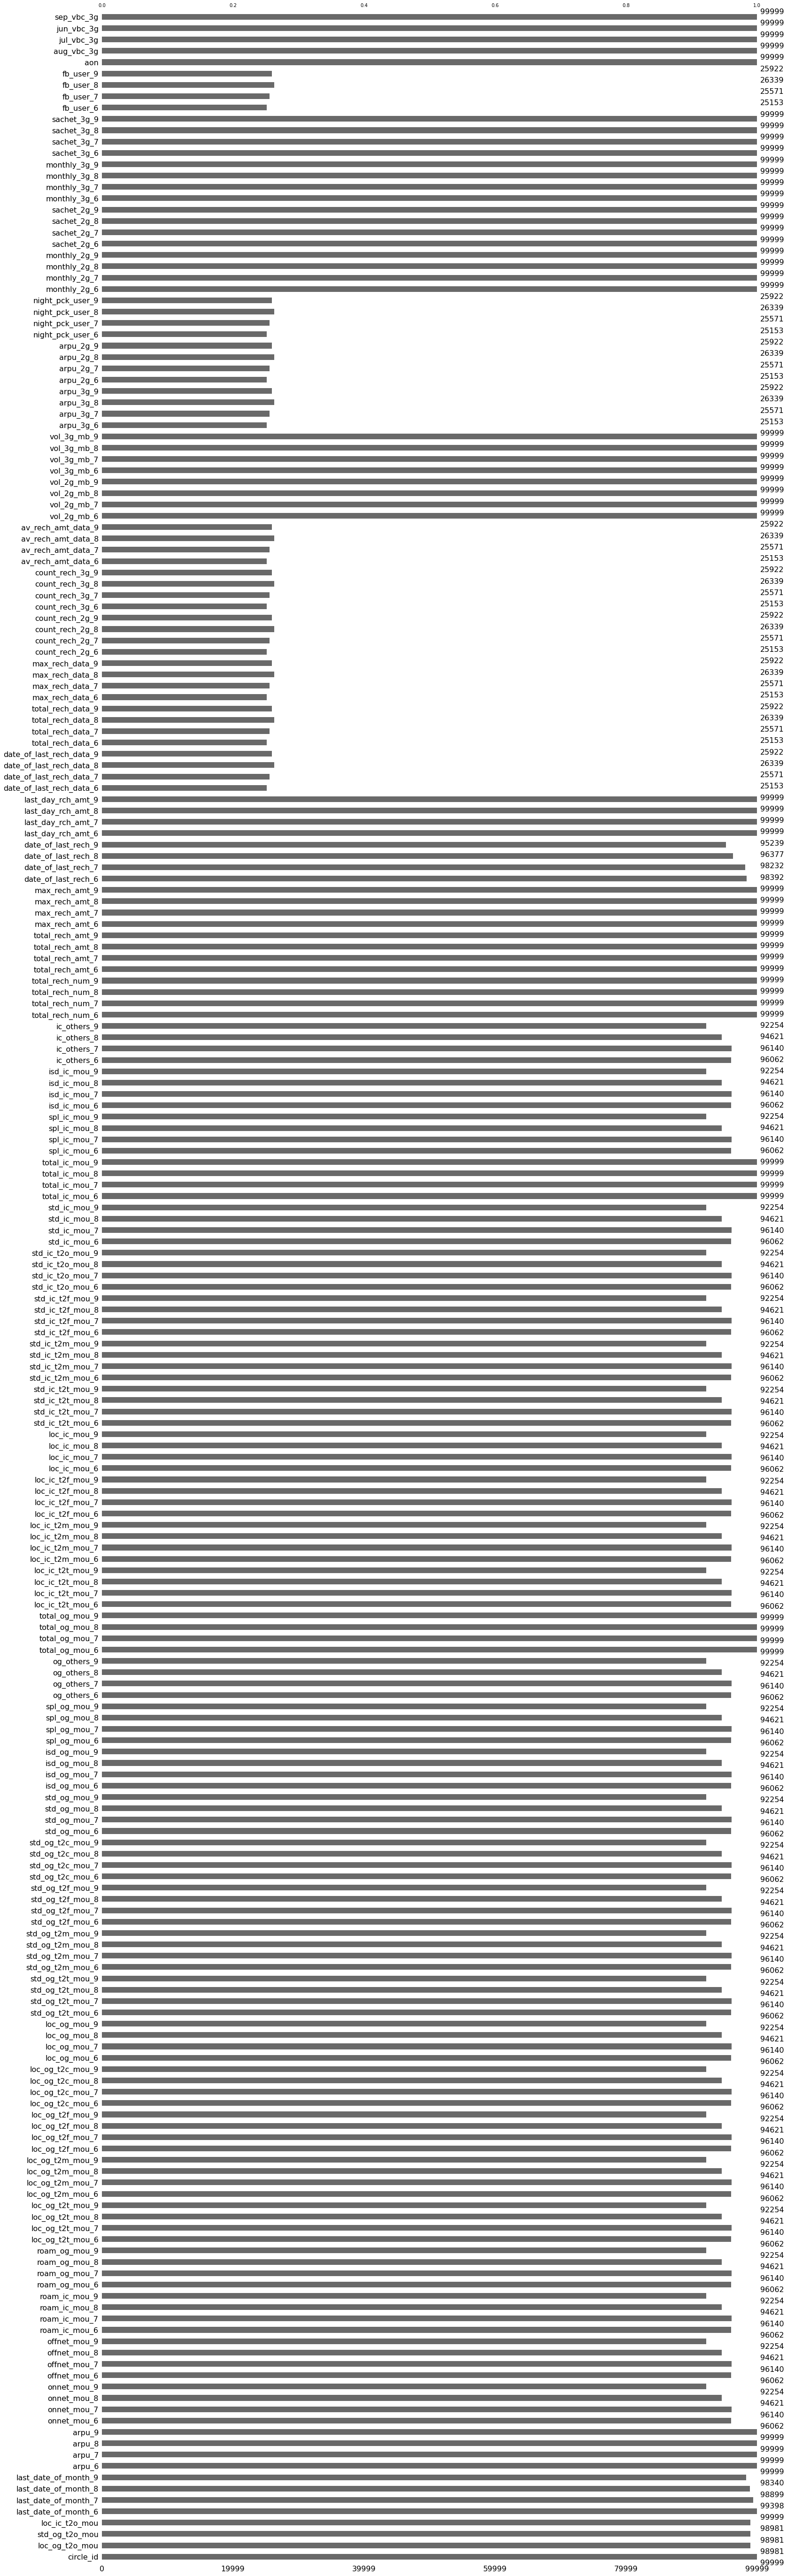

In [10]:
msn.bar(master_data_set)

- No missing values in total_rech_amt_* columns. 



- But total_rech_data_* and av_rech_amt_data_* are having missing values. 
- Check if there is any pattern to the missing data in these columns.

In [11]:
data_columns_6 = ['max_rech_data_6','count_rech_2g_6', 'count_rech_3g_6','av_rech_amt_data_6', 'vol_2g_mb_6', 'vol_3g_mb_6',
                  'arpu_3g_6', 'arpu_2g_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6',
                  'date_of_last_rech_data_6','total_rech_data_6','fb_user_6', 'night_pck_user_6']
data_columns_7 = ['max_rech_data_7','count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'vol_2g_mb_7', 'vol_3g_mb_7',
                  'arpu_3g_7', 'arpu_2g_7', 'monthly_2g_7', 'sachet_2g_7', 'monthly_3g_7', 'sachet_3g_7', 
                  'date_of_last_rech_data_7','total_rech_data_7','fb_user_7', 'night_pck_user_7']
data_columns_8 = ['max_rech_data_8','count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8',
                  'arpu_3g_8', 'arpu_2g_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 
                  'date_of_last_rech_data_8','total_rech_data_8', 'fb_user_8', 'night_pck_user_8']

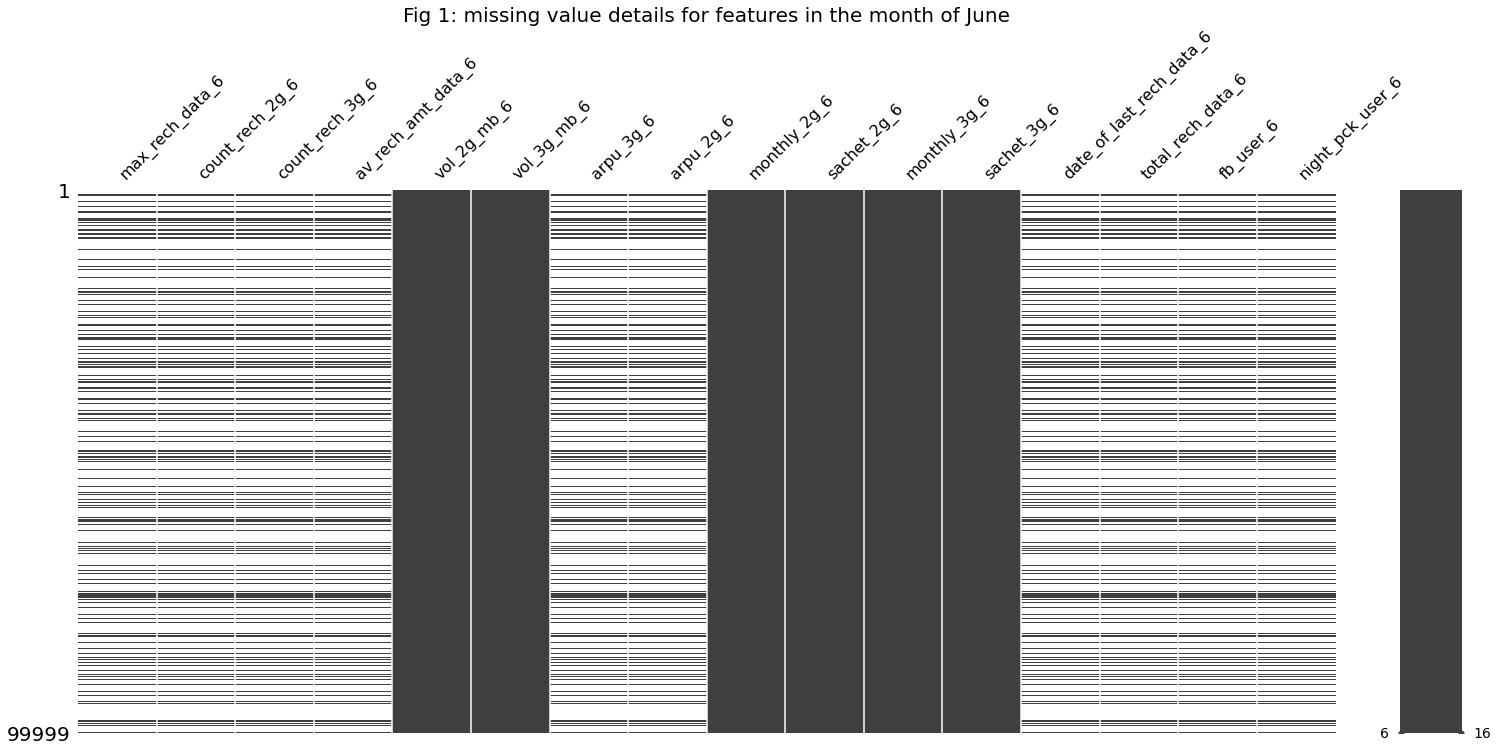

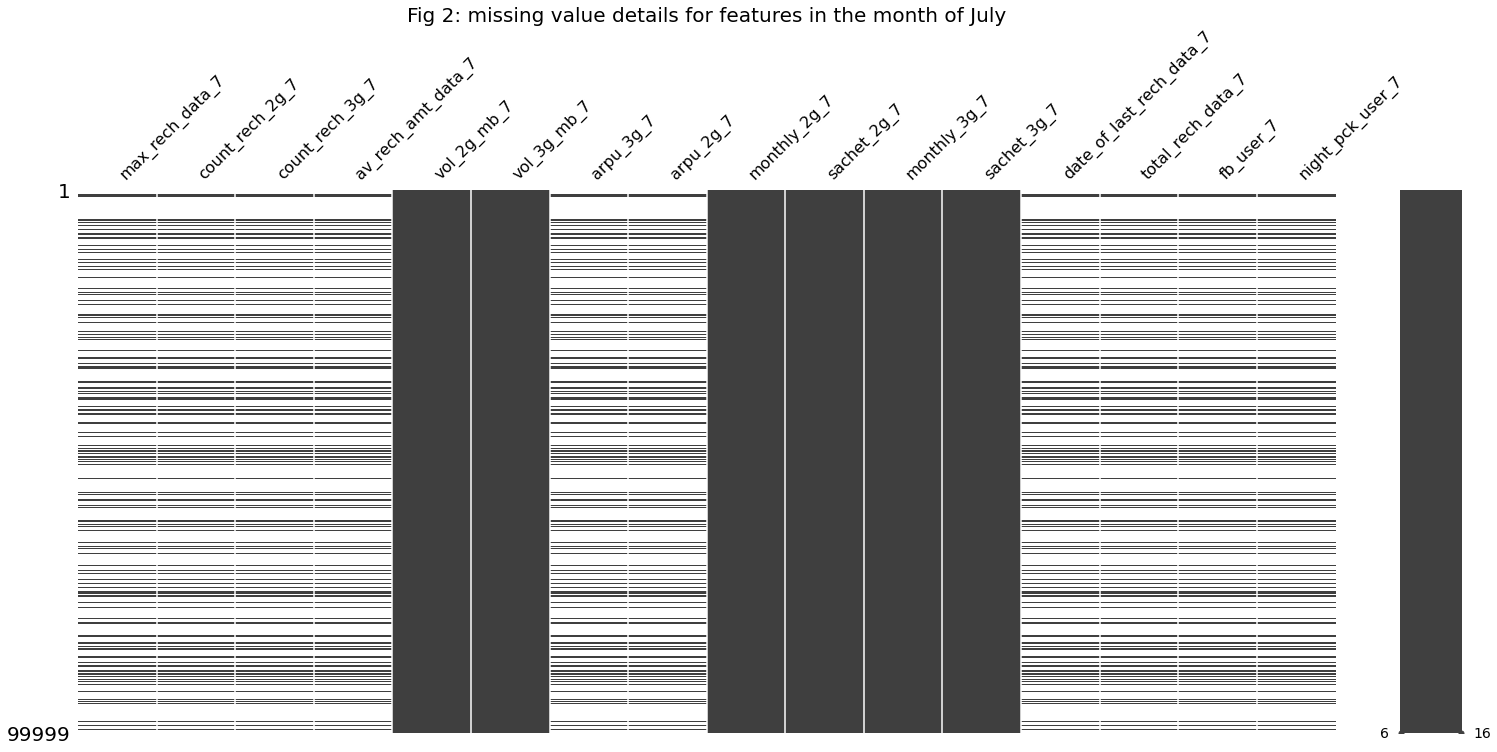

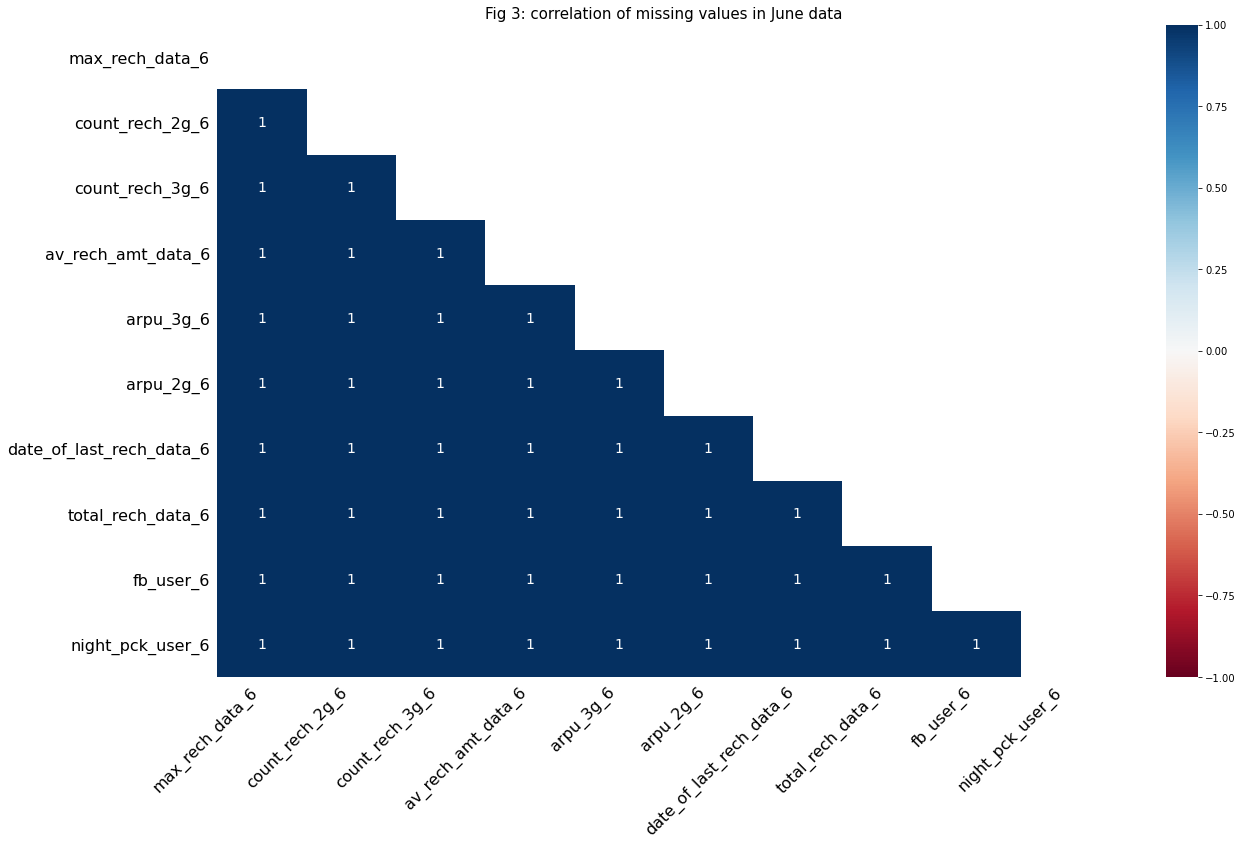

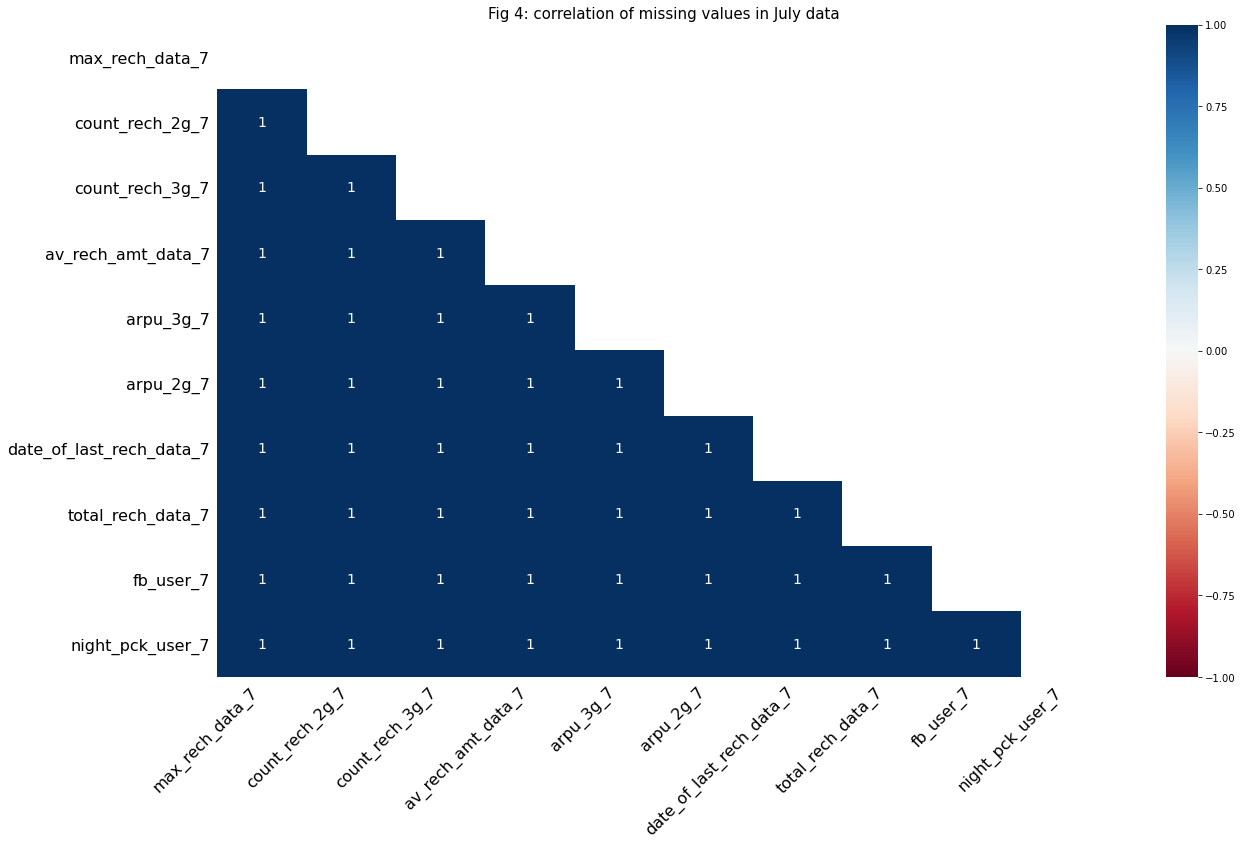

In [12]:
msn.matrix(master_data_set[data_columns_6])
plt.title('Fig 1: missing value details for features in the month of June', fontdict = {'fontsize' :20})
msn.matrix(master_data_set[data_columns_7])
plt.title('Fig 2: missing value details for features in the month of July', fontdict = {'fontsize' :20})
msn.heatmap(master_data_set[data_columns_6])
plt.title('Fig 3: correlation of missing values in June data', fontdict = {'fontsize' :15})
msn.heatmap(master_data_set[data_columns_7])
plt.title('Fig 4: correlation of missing values in July data', fontdict = {'fontsize' :15})
plt.show()

As per the above analysis, there aren't any misisng values for monthly_2g_*, sachet_2g_*, monthly_3g_*, sachet_3g_*,vol_2g_mb_* and vol_3g_mb_*. Rest of the columns related to data recharge are having a missing value correlation of 1 with each other. These data may not be available since those customers didn't do any data recharge during June and July. Let's verify this assumption by checking the data present for these customers in columns monthly_2g_*, monthly_3g_*, etc.

In [13]:
master_data_set.loc[master_data_set.total_rech_data_6.isnull(),['monthly_2g_6','sachet_2g_6','monthly_3g_6','sachet_3g_6',
                                                                'vol_2g_mb_6','vol_3g_mb_6']].sum()

monthly_2g_6    0.0
sachet_2g_6     0.0
monthly_3g_6    0.0
sachet_3g_6     0.0
vol_2g_mb_6     0.0
vol_3g_mb_6     0.0
dtype: float64

In [14]:
master_data_set.loc[master_data_set.total_rech_data_7.isnull(),['monthly_2g_7','sachet_2g_7','monthly_3g_7','sachet_3g_7',
                                                                'vol_2g_mb_7','vol_3g_mb_7']].sum()

monthly_2g_7    0.0
sachet_2g_7     0.0
monthly_3g_7    0.0
sachet_3g_7     0.0
vol_2g_mb_7     0.0
vol_3g_mb_7     0.0
dtype: float64

So we can confirm the above assumption since the data recharge details present for cutomers with missing entries in total_rech_data_6/7 have actually not done any data recharge in June and July. Hence impute max_rech_data_6/7,count_rech_2g_6/7,count_rech_3g_6/7, av_rech_amt_data_6/7, arpu_3g_6/7, arpu_2g_6/7, date_of_last_rech_data_6/7 & total_rech_data_6/7 with 0.

In [15]:
master_data_set.fillna({'max_rech_data_6':0,'count_rech_2g_6':0, 'count_rech_3g_6':0,'av_rech_amt_data_6':0, 'arpu_3g_6':0, 
                 'arpu_2g_6':0, 'date_of_last_rech_data_6':0,'total_rech_data_6':0,'fb_user_6':0, 'night_pck_user_6':0,
                 'max_rech_data_7':0,'count_rech_2g_7':0, 'count_rech_3g_7':0,'av_rech_amt_data_7':0, 'arpu_3g_7':0, 'arpu_2g_7':0,
                 'date_of_last_rech_data_7':0,'total_rech_data_7':0, 'fb_user_7':0, 'night_pck_user_7':0}, inplace = True)

- Above steps have to be done for Aug and Sep as well. But currently focusing on June and July to filter the dataset to contain only the high value customers



**Derive a new metric to represent average recharge amount in the first two months (the good phase)**

In [16]:
master_data_set['avg_all_rech_amt_GP'] = (master_data_set.total_rech_amt_6 + master_data_set.total_rech_amt_7 + 
                                    (master_data_set.total_rech_data_6 * master_data_set.av_rech_amt_data_6) + 
                                    (master_data_set.total_rech_data_7 * master_data_set.av_rech_amt_data_7))/4

In [17]:
pref_cust_df = master_data_set[master_data_set.avg_all_rech_amt_GP >= master_data_set.avg_all_rech_amt_GP.quantile(q = 0.7)]
pref_cust_df.reset_index(drop = True, inplace = True)
pref_cust_df.info(verbose = True,null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 226 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   circle_id                 30001 non-null  int64  
 1   loc_og_t2o_mou            29777 non-null  float64
 2   std_og_t2o_mou            29777 non-null  float64
 3   loc_ic_t2o_mou            29777 non-null  float64
 4   last_date_of_month_6      30001 non-null  object 
 5   last_date_of_month_7      29974 non-null  object 
 6   last_date_of_month_8      29836 non-null  object 
 7   last_date_of_month_9      29636 non-null  object 
 8   arpu_6                    30001 non-null  float64
 9   arpu_7                    30001 non-null  float64
 10  arpu_8                    30001 non-null  float64
 11  arpu_9                    30001 non-null  float64
 12  onnet_mou_6               29456 non-null  float64
 13  onnet_mou_7               29464 non-null  float64
 14  onnet

**Derive a feature to represent churn.**
- There aren't any missing values in total_og_mou_9,total_ic_mou_9,vol_2g_mb_9,vol_3g_mb_9
- take the sum and check if it's 0

In [18]:
pref_cust_df['churn'] = (((pref_cust_df.total_og_mou_9 + pref_cust_df.total_ic_mou_9) == 0) & 
                         ((pref_cust_df.vol_2g_mb_9 + pref_cust_df.vol_3g_mb_9) == 0))
pref_cust_df['churn'] = pref_cust_df['churn'].map({True:1,False:0})

##### Rate of churned customers present in the dataset

In [19]:
round((pref_cust_df.churn.value_counts()[1]/len(pref_cust_df))*100,2)

8.14

Now remove columns related to Sep month as this data won't be available during prediction of potential churn customers

In [20]:
pref_cust_df.drop(month_9_cols,axis = 1, inplace =True)
pref_cust_df.drop('sep_vbc_3g', axis = 1, inplace =True)

In [21]:
pref_cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Columns: 172 entries, circle_id to churn
dtypes: float64(136), int64(27), object(9)
memory usage: 39.4+ MB


Now the dataset with all necessary features are ready. 


**Data standardization, EDA, missing value treatment, outlier treatment have to be performed on this data set.**

##### Missing value treatment

In [22]:
missing_value = 100*(pref_cust_df.isnull().sum()/len(pref_cust_df))
missing_value[missing_value>=30]

date_of_last_rech_data_8    46.825106
total_rech_data_8           46.825106
max_rech_data_8             46.825106
count_rech_2g_8             46.825106
count_rech_3g_8             46.825106
av_rech_amt_data_8          46.825106
arpu_3g_8                   46.825106
arpu_2g_8                   46.825106
night_pck_user_8            46.825106
fb_user_8                   46.825106
dtype: float64

In [23]:
col_desc = pref_cust_df.describe()
col_desc

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_all_rech_amt_GP,churn
count,30001.0,29777.0,29777.0,29777.0,30001.000000,30001.000000,30001.000000,29456.000000,29464.000000,28827.000000,...,30001.000000,30001.000000,30001.000000,15953.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,109.0,0.0,0.0,0.0,558.490824,560.782203,508.597957,265.618262,272.700470,243.646938,...,0.202393,0.517483,0.524049,0.897198,1209.368754,169.138860,178.872765,158.523962,576.310314,0.081364
std,0.0,0.0,0.0,0.0,460.640461,479.776947,501.961981,462.493645,482.972367,465.200856,...,1.100107,0.499703,0.499430,0.303710,957.677989,420.974354,443.544138,416.734860,679.356991,0.273398
min,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,239.000000,0.000000
25%,109.0,0.0,0.0,0.0,309.865000,309.826000,231.473000,19.240000,18.155000,14.255000,...,0.000000,0.000000,0.000000,1.000000,460.000000,0.000000,0.000000,0.000000,301.500000,0.000000
50%,109.0,0.0,0.0,0.0,481.694000,480.943000,427.585000,88.060000,86.885000,72.930000,...,0.000000,1.000000,1.000000,1.000000,846.000000,0.000000,0.000000,0.000000,400.000000,0.000000
75%,109.0,0.0,0.0,0.0,699.943000,698.315000,661.491000,297.415000,298.087500,255.025000,...,0.000000,1.000000,1.000000,1.000000,1756.000000,128.800000,137.290000,98.440000,604.000000,0.000000
max,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,...,41.000000,1.000000,1.000000,1.000000,4321.000000,12916.220000,9165.600000,11166.210000,30618.000000,1.000000


In [24]:
# identify fetaures which are having the same value for all customers.
col_desc.loc[:,(col_desc.loc['std',:] == 0)]

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
count,30001.0,29777.0,29777.0,29777.0,29456.0,29464.0,28827.0,29456.0,29464.0,28827.0
mean,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


All the entries in each of the following columns are same. Hence they won't add any value to our business objective. These columns can be removed.
- circle_id, loc_og_t2o_mou, std_og_t2o_mou, loc_ic_t2o_mou, std_og_t2c_mou_6, std_og_t2c_mou_7, std_og_t2c_mou_8, std_ic_t2o_mou_6, std_ic_t2o_mou_7, std_ic_t2o_mou_8

In [25]:
cols_drop = list(col_desc.loc[:,(col_desc.loc['std',:] == 0)].columns)
pref_cust_df.drop(cols_drop, axis = 1, inplace = True)

**Check columns with object datatype**

In [26]:
pref_cust_df.select_dtypes(include = 'object')

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/30/2014,7/31/2014,8/31/2014,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
1,6/30/2014,7/31/2014,8/31/2014,6/27/2014,7/25/2014,8/26/2014,0,0,NaN
2,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/31/2014,8/30/2014,0,7/31/2014,8/23/2014
3,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/31/2014,8/31/2014,0,0,NaN
4,6/30/2014,7/31/2014,8/31/2014,6/18/2014,7/7/2014,8/24/2014,0,7/7/2014,8/6/2014
...,...,...,...,...,...,...,...,...,...
29996,6/30/2014,7/31/2014,8/31/2014,6/17/2014,7/25/2014,8/27/2014,6/17/2014,7/14/2014,8/23/2014
29997,6/30/2014,7/31/2014,8/31/2014,6/21/2014,7/31/2014,8/27/2014,6/15/2014,7/31/2014,8/27/2014
29998,6/30/2014,7/31/2014,8/31/2014,6/20/2014,7/28/2014,8/18/2014,6/17/2014,7/18/2014,8/14/2014
29999,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/28/2014,8/29/2014,0,7/26/2014,8/23/2014


**Conclusion:**

date_of_last_rech_data_6 & date_of_last_rech_data_7 are having values 0 in it, since we have imputed it as 0 (customer did not make a data recharge). 

Let's replace it with last day of the respective month and calculate new features representing no.of days since last recharge.



**Treat the missing values in these columns before deriving new metrics**

In [27]:
for item in list(pref_cust_df.select_dtypes(include = 'object').columns):
    print((item, item in list(missing_value[missing_value>0].index)))

('last_date_of_month_6', False)
('last_date_of_month_7', True)
('last_date_of_month_8', True)
('date_of_last_rech_6', True)
('date_of_last_rech_7', True)
('date_of_last_rech_8', True)
('date_of_last_rech_data_6', False)
('date_of_last_rech_data_7', False)
('date_of_last_rech_data_8', True)


- Features to be treated for missing values before deriving new features
    1. last_date_of_month_7
    2. last_date_of_month_8
    3. date_of_last_rech_6
    4. date_of_last_rech_7
    5. date_of_last_rech_8 
    6. date_of_last_rech_data_8
- Features for which entries 0 has to be replaced with last day of the month
    7. date_of_last_rech_data_6
    8. date_of_last_rech_data_7

- Treat: 
    1. last_date_of_month_7 
    2. last_date_of_month_8

**Check if last_date_of_month_6/7/8 are correct**

In [28]:
print('June last date:',pref_cust_df.last_date_of_month_6.unique(), 'July last date:',pref_cust_df.last_date_of_month_7.unique(),
     'Aug last date:',pref_cust_df.last_date_of_month_8.unique())

June last date: ['6/30/2014'] July last date: ['7/31/2014' nan] Aug last date: ['8/31/2014' nan]


**Replace the missing values in last_date_of_month_7 and last_date_of_month_8 with proper date**

In [29]:
pref_cust_df.fillna({'last_date_of_month_7': '7/31/2014', 'last_date_of_month_8':'8/31/2014'}, inplace =True)

- Treat:
    3. date_of_last_rech_6
    4. date_of_last_rech_7
    5. date_of_last_rech_8

**date_of_last_rech_6, date_of_last_rech_7, date_of_last_rech_8 are having misisng values.**


- Check if it's because the customer hasn't done any recharge

In [30]:
print('recharges in June:',pref_cust_df.loc[pref_cust_df['date_of_last_rech_6'].isnull(),['total_rech_num_6']].sum()[0],'\n',
     'recharges in July:',pref_cust_df.loc[pref_cust_df['date_of_last_rech_7'].isnull(),['total_rech_num_7']].sum()[0],'\n',
     'recharges in Aug:',pref_cust_df.loc[pref_cust_df['date_of_last_rech_8'].isnull(),['total_rech_num_8']].sum()[0])

recharges in June: 0 
 recharges in July: 0 
 recharges in Aug: 0


As we can see above, the missing entries in date_of_last_rech_6, date_of_last_rech_7, date_of_last_rech_8 are due to lack of recharge by customer. So these entries can be filled with laste date of the month.

In [31]:
pref_cust_df.fillna({'date_of_last_rech_6': '6/30/2014', 'date_of_last_rech_7':'7/31/2014', 
                     'date_of_last_rech_8':'8/31/2014'}, inplace =True)

- Treat:
    6. date_of_last_rech_data_8

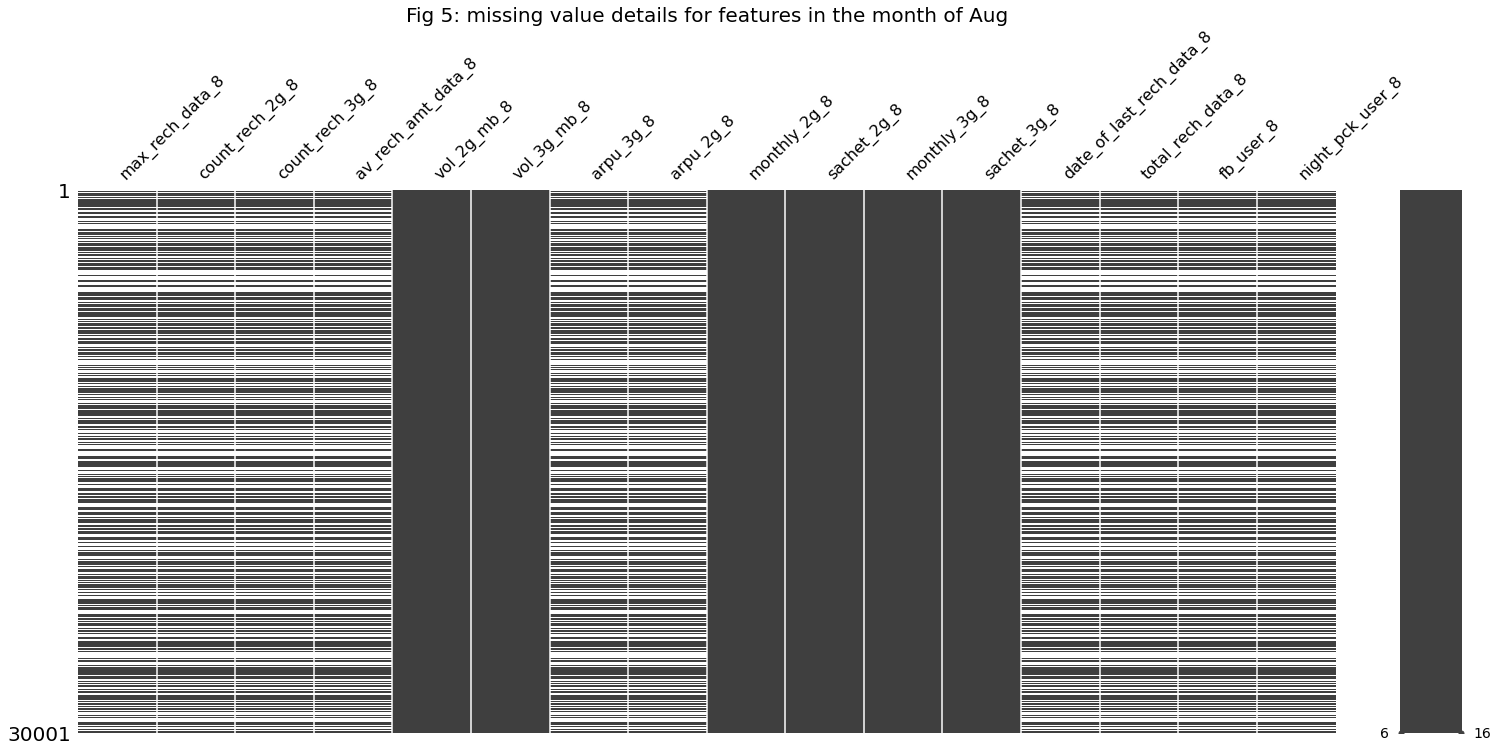

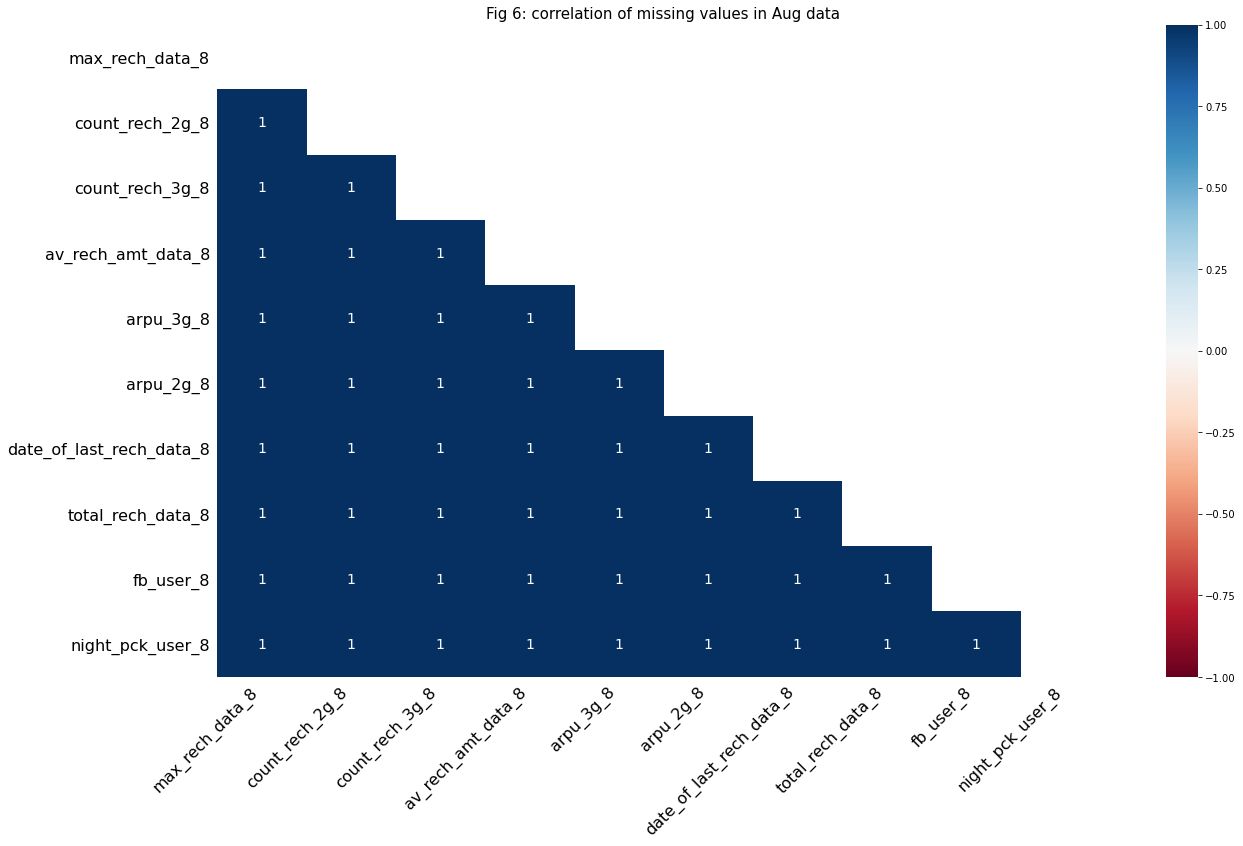

monthly_2g_8    0.0
sachet_2g_8     0.0
monthly_3g_8    0.0
sachet_3g_8     0.0
vol_2g_mb_8     0.0
vol_3g_mb_8     0.0
dtype: float64

In [32]:
msn.matrix(pref_cust_df[data_columns_8])
plt.title('Fig 5: missing value details for features in the month of Aug', fontdict = {'fontsize' :20})
msn.heatmap(master_data_set[data_columns_8])
plt.title('Fig 6: correlation of missing values in Aug data', fontdict = {'fontsize' :15})
plt.show()
master_data_set.loc[master_data_set.total_rech_data_6.isnull(),['monthly_2g_8','sachet_2g_8','monthly_3g_8','sachet_3g_8',
                                                                'vol_2g_mb_8','vol_3g_mb_8']].sum()

We can see that there weren't any data recharge done by the customers in Aug for whom date_of_last_rech_data_8 column was empty. So we can impute these empty values with last day of the month

In [33]:
pref_cust_df.fillna({'date_of_last_rech_data_8': '8/31/2014'},inplace  =True)

- Treat:
    7. date_of_last_rech_data_6
    8. date_of_last_rech_data_7

In [34]:
pref_cust_df['date_of_last_rech_data_6'] = pref_cust_df['date_of_last_rech_data_6'].replace({0:'6/30/2014'})
pref_cust_df['date_of_last_rech_data_7'] = pref_cust_df['date_of_last_rech_data_7'].replace({0:'7/31/2014'})

In [35]:
pref_cust_df[['date_of_last_rech_data_6','date_of_last_rech_data_7']][:5]

,date_of_last_rech_data_6,date_of_last_rech_data_7
0,6/21/2014,7/16/2014
1,6/30/2014,7/31/2014
2,6/30/2014,7/31/2014
3,6/30/2014,7/31/2014
4,6/30/2014,7/7/2014


**All coulmns with object datatypes are timestamps. Let's convert these into TS format.**

In [36]:
for col in list(pref_cust_df.select_dtypes(include = 'object').columns):
    pref_cust_df[col] = pd.to_datetime(pref_cust_df[col], format = '%m/%d/%Y',errors = 'ignore')

In [37]:
# check if monthly_3g_7+sachet_3g_7 == count_rech_3g_7
((pref_cust_df.monthly_3g_7+pref_cust_df.sachet_3g_7) == pref_cust_df.count_rech_3g_7).sum()

30001

**Column definitions:**
- total_rech_data_*: total no. of data recharge
- count_rech_2g_*: total no. of 2G recharge
- count_rech_3g_*: total no. of 3G recharge
- monthly_2g_*: no. of 2G recharges in a month
- monthly_3g_*: no. of 3G recharges in a month
- sachet_2g_*: no. of 2G sachet recharges in a month
- sachet_3g_*: no. of 3G sachet recharges in a month

#### Derive new features
    1. calculate new features representing no.of days since last recharge
    2. total_data_vol_6 = vol_2g_mb_6+vol_3g_mb_6
    3. count_monthly_data_rec_6 = monthly_2g_6+ monthly_3g_6
    4. count_monthly_sachet_rec_6 = sachet_2g_6+sachet_3g_6
    5. arpu_data_6 = arpu_3g_6+arpu_2g_6
    6. total_data_rech_amt_6 = av_rech_amt_data_6*total_rech_data_6

**1. Calculate new features representing no.of days since last recharge**

In [38]:
pref_cust_df['last_data_rec_num_days_6'] = (pref_cust_df.last_date_of_month_6 - pref_cust_df.date_of_last_rech_data_6).dt.days
pref_cust_df['last_data_rec_num_days_7'] = (pref_cust_df.last_date_of_month_7 - pref_cust_df.date_of_last_rech_data_7).dt.days
pref_cust_df['last_data_rec_num_days_8'] = (pref_cust_df.last_date_of_month_8 - pref_cust_df.date_of_last_rech_data_8).dt.days

pref_cust_df['last_rec_num_days_6'] = (pref_cust_df.last_date_of_month_6 - pref_cust_df.date_of_last_rech_6).dt.days
pref_cust_df['last_rec_num_days_7'] = (pref_cust_df.last_date_of_month_7 - pref_cust_df.date_of_last_rech_7).dt.days
pref_cust_df['last_rec_num_days_8'] = (pref_cust_df.last_date_of_month_8 - pref_cust_df.date_of_last_rech_8).dt.days
pref_cust_df.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8', 'date_of_last_rech_data_6', 
                   'date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_6','date_of_last_rech_7',
                  'date_of_last_rech_8'], axis = 1, inplace = True)

To derive above mentioned features (2 to 6), treat the missing values in columns first

In [39]:
round(100*(pref_cust_df[['vol_2g_mb_6', 'vol_3g_mb_6', 'monthly_2g_6', 'monthly_3g_6', 'sachet_2g_6', 'sachet_3g_6',
                  'arpu_3g_6', 'arpu_2g_6', 'av_rech_amt_data_6', 'total_rech_data_6',
                  'vol_2g_mb_7', 'vol_3g_mb_7', 'monthly_2g_7', 'monthly_3g_7', 'sachet_2g_7', 'sachet_3g_7',
                  'arpu_3g_7', 'arpu_2g_7', 'av_rech_amt_data_7', 'total_rech_data_7',
                  'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'monthly_3g_8', 'sachet_2g_8', 'sachet_3g_8',
                  'arpu_3g_8', 'arpu_2g_8', 'av_rech_amt_data_8', 'total_rech_data_8']].isnull().sum()/len(pref_cust_df))
      ,2).sort_values(ascending = False)

total_rech_data_8     46.83
arpu_2g_8             46.83
arpu_3g_8             46.83
av_rech_amt_data_8    46.83
monthly_2g_7           0.00
vol_3g_mb_6            0.00
monthly_2g_6           0.00
monthly_3g_6           0.00
sachet_2g_6            0.00
sachet_3g_6            0.00
arpu_3g_6              0.00
arpu_2g_6              0.00
av_rech_amt_data_6     0.00
total_rech_data_6      0.00
vol_2g_mb_7            0.00
vol_3g_mb_7            0.00
sachet_2g_7            0.00
monthly_3g_7           0.00
sachet_3g_7            0.00
arpu_3g_7              0.00
arpu_2g_7              0.00
av_rech_amt_data_7     0.00
total_rech_data_7      0.00
vol_2g_mb_8            0.00
vol_3g_mb_8            0.00
monthly_2g_8           0.00
monthly_3g_8           0.00
sachet_2g_8            0.00
sachet_3g_8            0.00
vol_2g_mb_6            0.00
dtype: float64

Total_rech_data_8, arpu_2g_8, arpu_3g_8 and av_rech_amt_data_8 have missing values in them. 

By checking the previously generated bar graph and correlation matrix of month 8 (Fig 5 & Fig 6), we can infer that the missing entries are due to 0 recharge made by customer. 

Hence, we can impute these entries with 0.

In [40]:
pref_cust_df.fillna({'total_rech_data_8':0, 'arpu_2g_8':0, 'arpu_3g_8':0, 'av_rech_amt_data_8':0, 
                     'count_rech_3g_8':0,'max_rech_data_8':0, 'count_rech_2g_8':0, 'fb_user_8':0, 'night_pck_user_8':0}, inplace =True) 

In [41]:
pref_cust_df['total_data_vol_6'] = pref_cust_df.vol_2g_mb_6 + pref_cust_df.vol_3g_mb_6
pref_cust_df['count_monthly_data_rec_6'] = pref_cust_df.monthly_2g_6 + pref_cust_df.monthly_3g_6
pref_cust_df['count_monthly_sachet_rec_6'] = pref_cust_df.sachet_2g_6 + pref_cust_df.sachet_3g_6
pref_cust_df['arpu_data_6'] = pref_cust_df.arpu_3g_6 + pref_cust_df.arpu_2g_6
pref_cust_df['total_data_rech_amt_6'] = pref_cust_df.av_rech_amt_data_6 * pref_cust_df.total_rech_data_6

pref_cust_df['total_data_vol_7'] = pref_cust_df.vol_2g_mb_7 + pref_cust_df.vol_3g_mb_7
pref_cust_df['count_monthly_data_rec_7'] = pref_cust_df.monthly_2g_7 + pref_cust_df.monthly_3g_7
pref_cust_df['count_monthly_sachet_rec_7'] = pref_cust_df.sachet_2g_7 + pref_cust_df.sachet_3g_7
pref_cust_df['arpu_data_7'] = pref_cust_df.arpu_3g_7 + pref_cust_df.arpu_2g_7
pref_cust_df['total_data_rech_amt_7'] = pref_cust_df.av_rech_amt_data_7 * pref_cust_df.total_rech_data_7

pref_cust_df['total_data_vol_8'] = pref_cust_df.vol_2g_mb_8 + pref_cust_df.vol_3g_mb_8
pref_cust_df['count_monthly_data_rec_8'] = pref_cust_df.monthly_2g_8 + pref_cust_df.monthly_3g_8
pref_cust_df['count_monthly_sachet_rec_8'] = pref_cust_df.sachet_2g_8 + pref_cust_df.sachet_3g_8
pref_cust_df['arpu_data_8'] = pref_cust_df.arpu_3g_8 + pref_cust_df.arpu_2g_8
pref_cust_df['total_data_rech_amt_8'] = pref_cust_df.av_rech_amt_data_8 * pref_cust_df.total_rech_data_8

pref_cust_df.drop(['vol_2g_mb_6', 'vol_3g_mb_6', 'monthly_2g_6', 'monthly_3g_6', 'sachet_2g_6', 'sachet_3g_6',
                  'arpu_3g_6', 'arpu_2g_6', 'av_rech_amt_data_6', 
                  'vol_2g_mb_7', 'vol_3g_mb_7', 'monthly_2g_7', 'monthly_3g_7', 'sachet_2g_7', 'sachet_3g_7',
                  'arpu_3g_7', 'arpu_2g_7', 'av_rech_amt_data_7',
                  'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'monthly_3g_8', 'sachet_2g_8', 'sachet_3g_8',
                  'arpu_3g_8', 'arpu_2g_8', 'av_rech_amt_data_8'], axis = 1, inplace = True)

In [42]:
pref_cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Columns: 147 entries, arpu_6 to total_data_rech_amt_8
dtypes: float64(121), int64(26)
memory usage: 33.6 MB


- Handle missing values with the help of correlated variabales (business understanding) and then drop highly correlated vars

In [43]:
missing_value = round(100*(pref_cust_df.isnull().sum()/pref_cust_df.shape[0]).sort_values(ascending =False),2)
missing_value = missing_value[missing_value>0]
miss_6 = [item for item in list(missing_value.index) if '_6' in item]
miss_7 = [item for item in list(missing_value.index) if '_7' in item]
miss_8 = [item for item in list(missing_value.index) if '_8' in item]

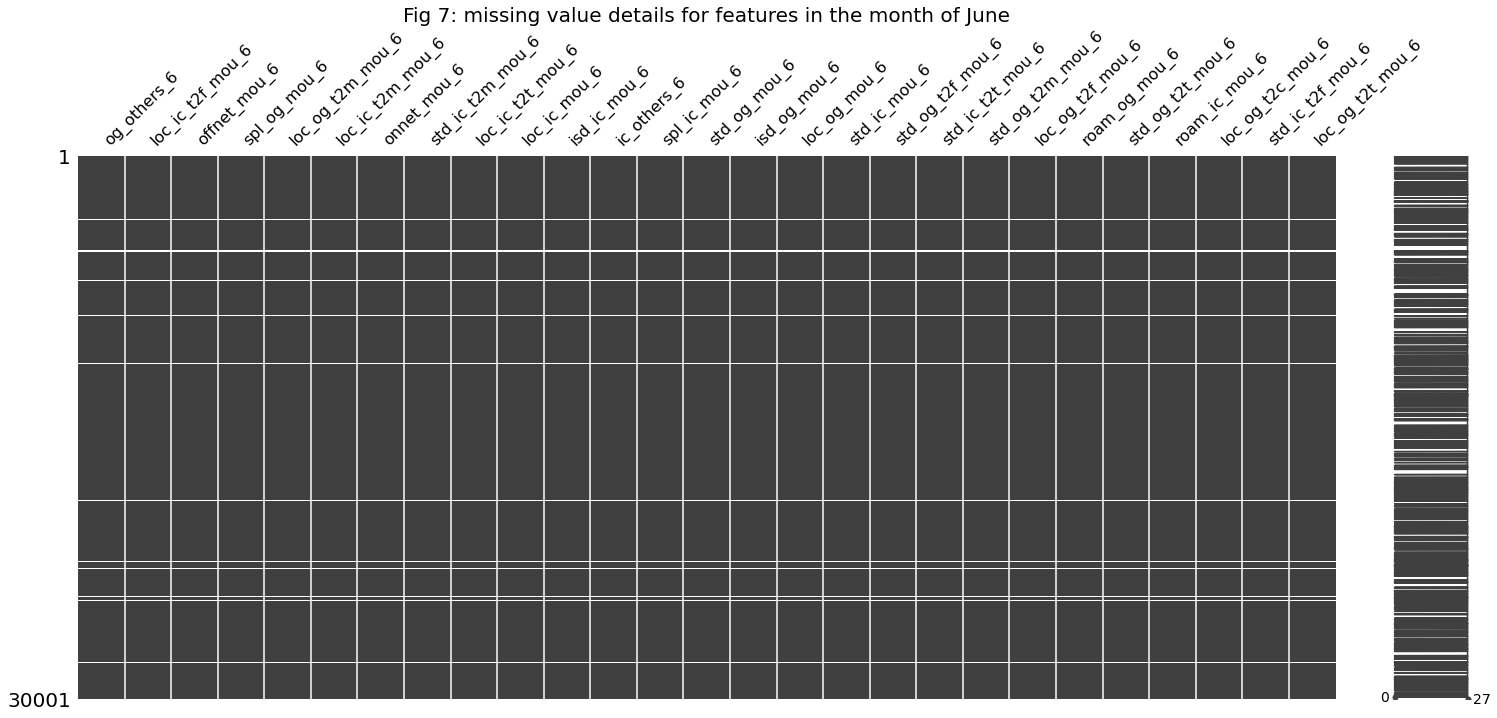

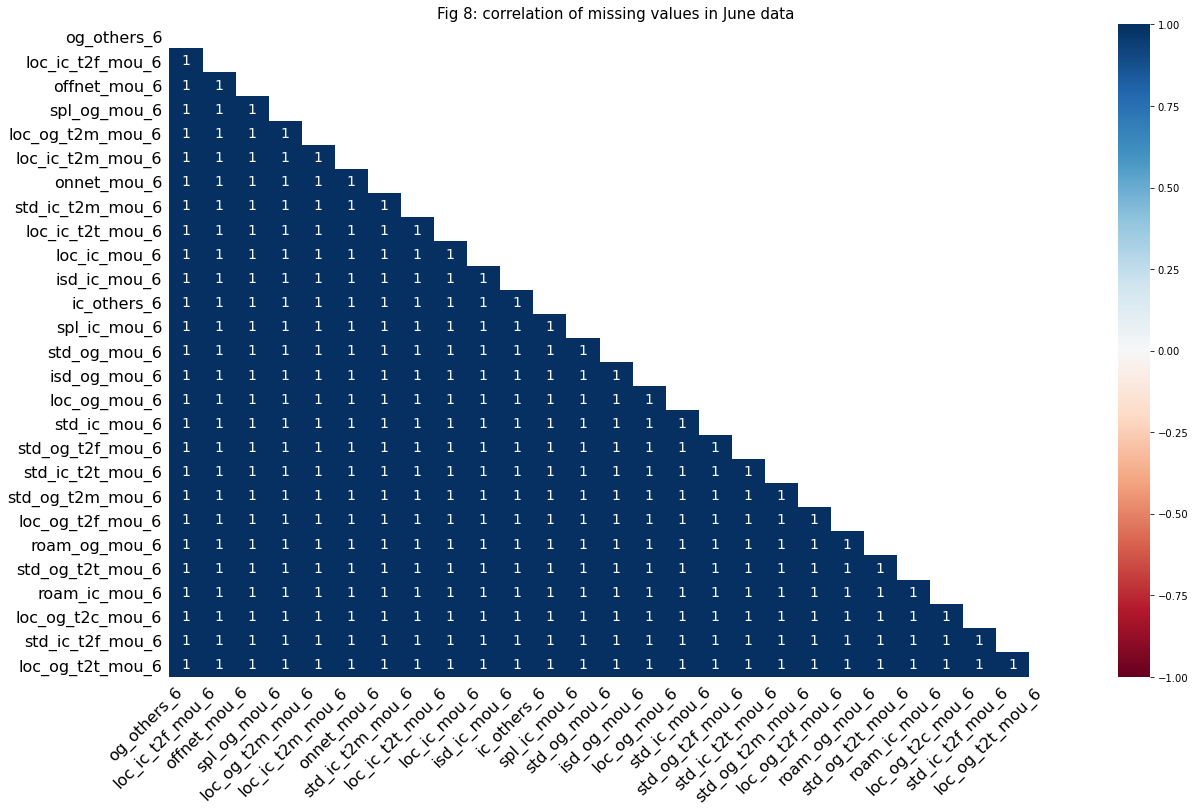

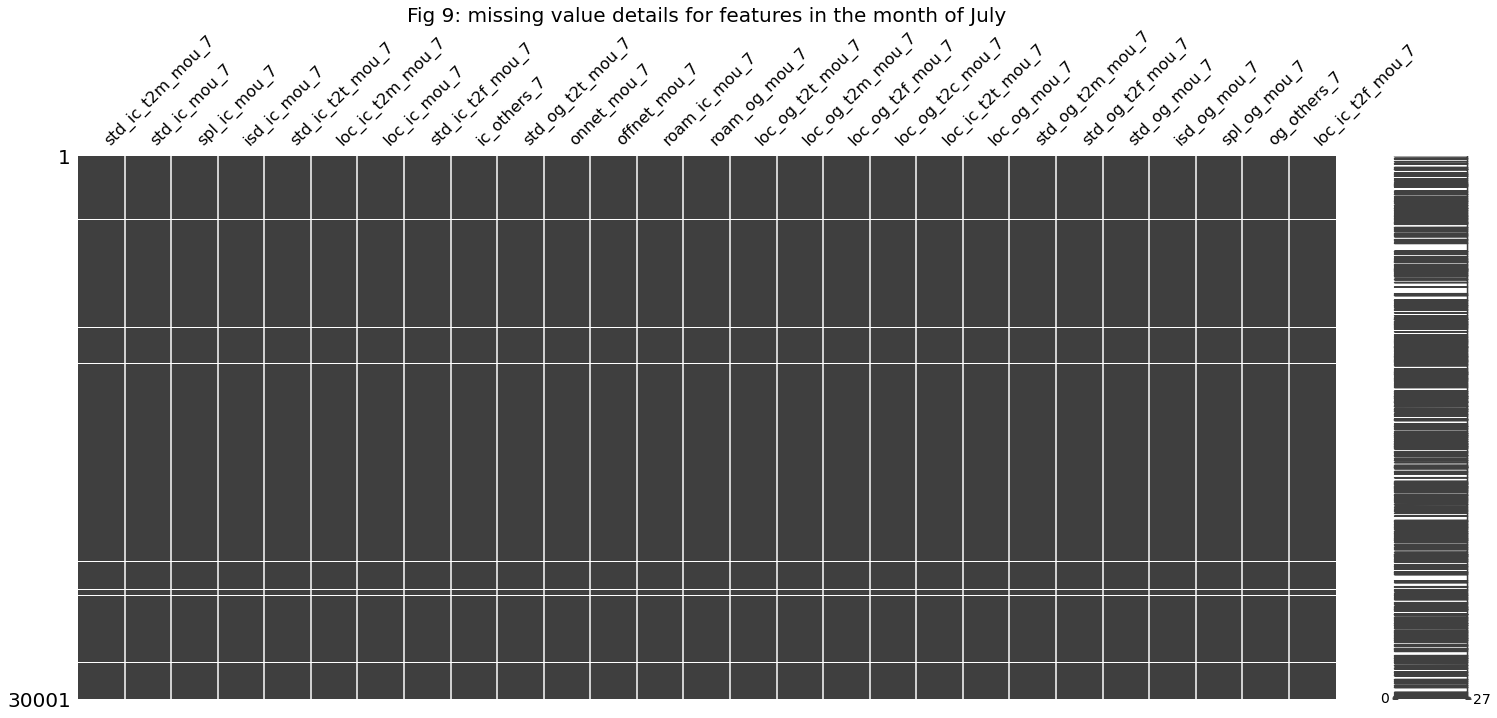

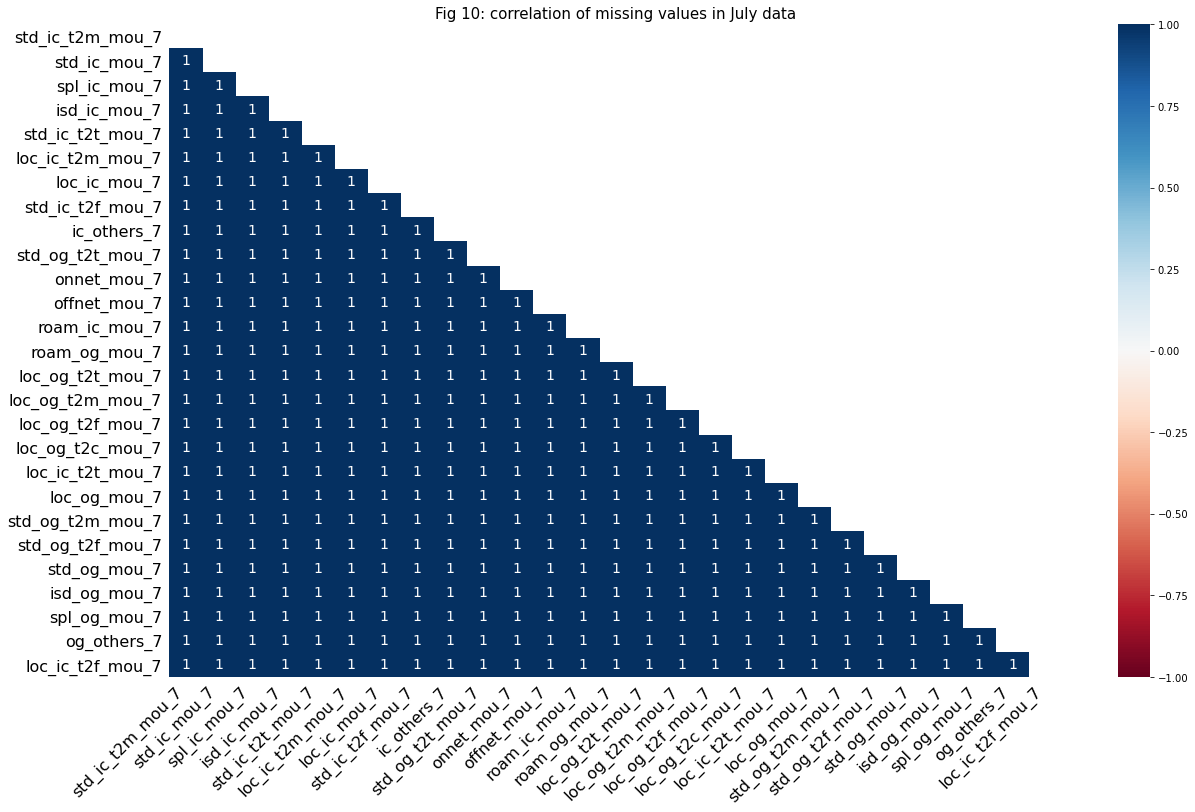

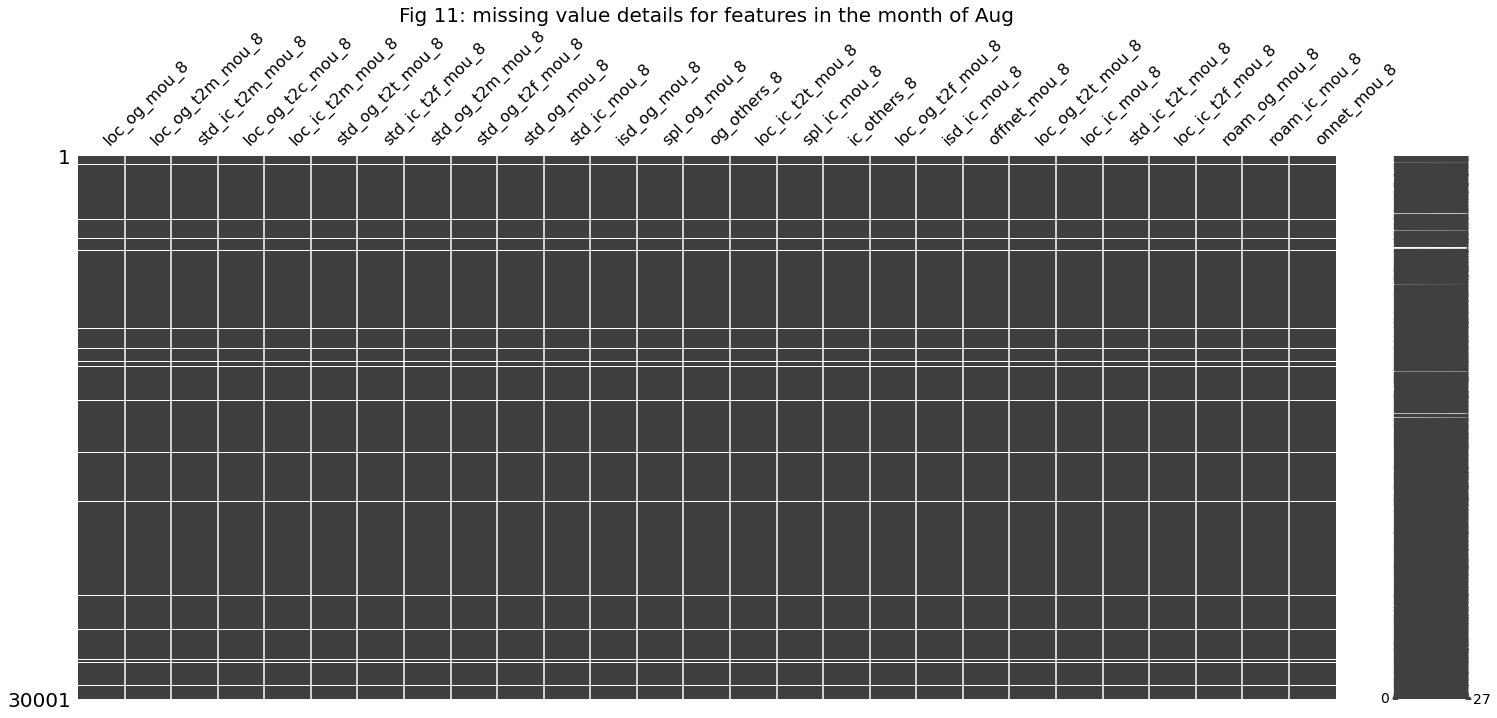

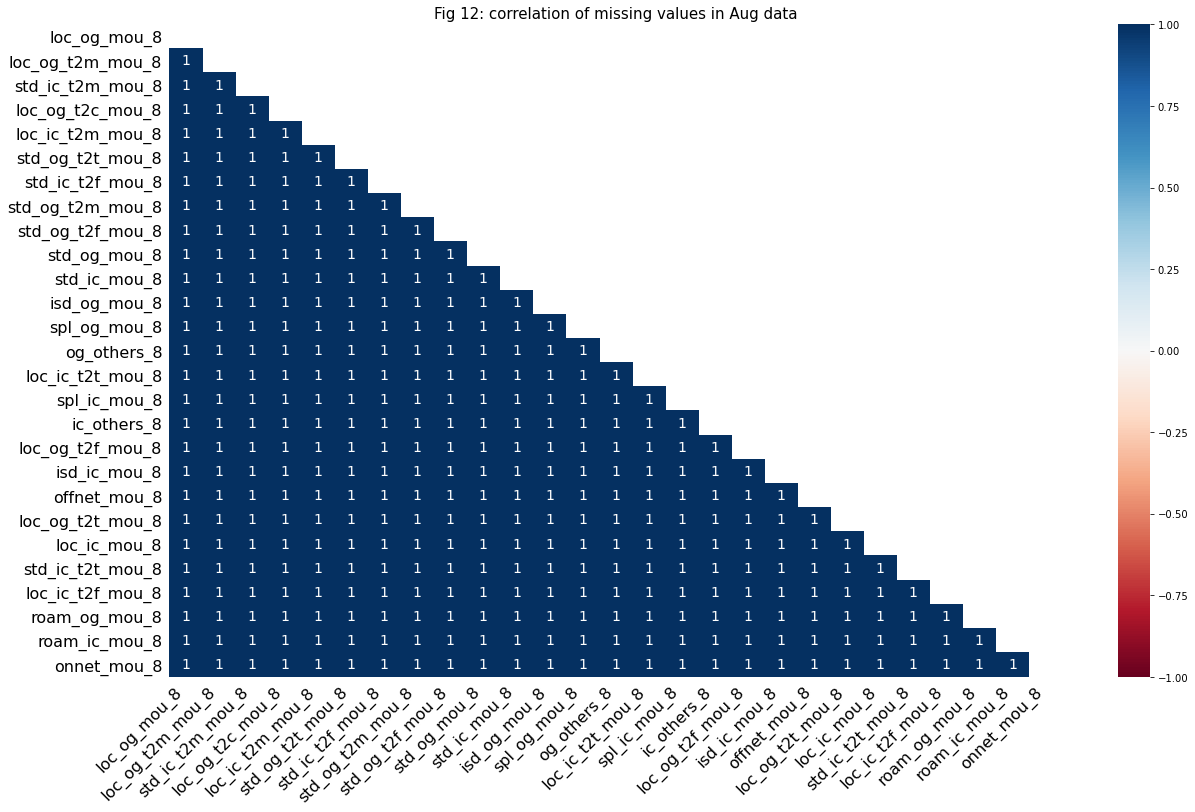

In [44]:
msn.matrix(pref_cust_df[miss_6])
plt.title('Fig 7: missing value details for features in the month of June', fontdict = {'fontsize' :20})
msn.heatmap(master_data_set[miss_6])
plt.title('Fig 8: correlation of missing values in June data', fontdict = {'fontsize' :15})

msn.matrix(pref_cust_df[miss_7])
plt.title('Fig 9: missing value details for features in the month of July', fontdict = {'fontsize' :20})
msn.heatmap(master_data_set[miss_7])
plt.title('Fig 10: correlation of missing values in July data', fontdict = {'fontsize' :15})

msn.matrix(pref_cust_df[miss_8])
plt.title('Fig 11: missing value details for features in the month of Aug', fontdict = {'fontsize' :20})
msn.heatmap(master_data_set[miss_8])
plt.title('Fig 12: correlation of missing values in Aug data', fontdict = {'fontsize' :15})

plt.show()

Missing values of each month are perfectly correlated with each other. All features are related to incoming and outgoing call duration. One possible reason would be that the customer neither made any calls nor received any calls. 


Let's verify this by checking total_og_mou_6 and total_ic_mou_6

In [45]:
pref_cust_df.loc[pref_cust_df.loc_ic_mou_6.isnull(),['total_ic_mou_6','total_og_mou_6']].sum()

total_ic_mou_6    0.0
total_og_mou_6    0.0
dtype: float64

As we can see the total minutes of usage for incoming and outgoing are 0 for customers with missing values in the above-mentioned columns, we can confirm our above assumption and hence impute these entries with 0.

In [46]:
pref_cust_df[miss_6] = pref_cust_df[miss_6].fillna(value = 0)
pref_cust_df[miss_7] = pref_cust_df[miss_7].fillna(value = 0)
pref_cust_df[miss_8] = pref_cust_df[miss_8].fillna(value = 0)

In [47]:
# recheck the missing values
(round(100*(pref_cust_df.isnull().sum()/pref_cust_df.shape[0]),2)>0).sum()

0

**Check correlation of features for June, July & Aug**

In [48]:
# 1. June
month_6_cols = [item for item in list(pref_cust_df.columns) if '_6' in item]
corr_matrix = pref_cust_df[month_6_cols].corr().abs().unstack().sort_values().drop_duplicates()
print('June: Highly correlated vars (>0.8)):','\n',corr_matrix[corr_matrix>0.8])
# 2. July
month_7_cols = [item for item in list(pref_cust_df.columns) if '_7' in item]
corr_matrix = pref_cust_df[month_7_cols].corr().abs().unstack().sort_values().drop_duplicates()
print('\n','July: Highly correlated vars (>0.8)):','\n',corr_matrix[corr_matrix>0.8])
# 3. Aug
month_8_cols = [item for item in list(pref_cust_df.columns) if '_8' in item]
corr_matrix = pref_cust_df[month_8_cols].corr().abs().unstack().sort_values().drop_duplicates()
print('\n','Aug: Highly correlated vars (>0.8)):','\n',corr_matrix[corr_matrix>0.8])

June: Highly correlated vars (>0.8)): 
 loc_og_mou_6                loc_og_t2m_mou_6     0.804608
std_ic_mou_6                std_ic_t2m_mou_6     0.814196
offnet_mou_6                std_og_t2m_mou_6     0.830354
total_og_mou_6              std_og_mou_6         0.834123
loc_ic_mou_6                loc_ic_t2m_mou_6     0.845084
std_og_t2t_mou_6            onnet_mou_6          0.859409
loc_ic_mou_6                total_ic_mou_6       0.896472
count_rech_2g_6             total_rech_data_6    0.911384
count_monthly_sachet_rec_6  count_rech_2g_6      0.923631
total_rech_amt_6            arpu_6               0.946125
count_monthly_sachet_rec_6  total_rech_data_6    0.967622
arpu_6                      arpu_6               1.000000
dtype: float64

 July: Highly correlated vars (>0.8)): 
 std_ic_mou_7                std_ic_t2m_mou_7     0.819554
loc_ic_mou_7                loc_ic_t2m_mou_7     0.835261
std_og_mou_7                total_og_mou_7       0.849694
offnet_mou_7                std_o

**Drop highly correlated varaibles**
- loc_og_t2m_mou_6, std_ic_t2m_mou_6, std_og_t2m_mou_6, std_og_mou_6, loc_ic_t2m_mou_6, std_og_t2t_mou_6, loc_ic_mou_6, count_rech_2g_6, count_monthly_sachet_rec_6, arpu_6
-  std_ic_t2m_mou_7, loc_ic_t2m_mou_7, std_og_mou_7, std_og_t2m_mou_7, std_og_t2t_mou_7,loc_ic_mou_7, count_rech_2g_7, count_monthly_sachet_rec_7, arpu_7
- std_ic_t2m_mou_8, loc_ic_t2m_mou_8, std_og_t2m_mou_8, std_og_mou_8, std_og_t2t_mou_8, loc_ic_mou_8, count_rech_2g_8, count_monthly_sachet_rec_8, arpu_8

**Keep the following as they have more relevance from business perspective**
- loc_og_mou_6, std_ic_mou_6, offnet_mou_6, total_og_mou_6, onnet_mou_6, total_ic_mou_6, total_rech_data_6
- std_ic_mou_7, total_og_mou_7, offnet_mou_7, total_ic_mou_7, total_rech_data_7, onnet_mou_7
- std_ic_mou_8, offnet_mou_8, total_og_mou_8, onnet_mou_8, total_ic_mou_8, total_rech_data_8

In [49]:
to_drop = ['loc_og_t2m_mou_6', 'std_ic_t2m_mou_6', 'std_og_t2m_mou_6', 'std_og_mou_6', 'loc_ic_t2m_mou_6', 'std_og_t2t_mou_6', 
           'loc_ic_mou_6', 'count_rech_2g_6', 'count_monthly_sachet_rec_6', 'arpu_6', 'std_ic_t2m_mou_7', 'loc_ic_t2m_mou_7', 
           'std_og_mou_7', 'std_og_t2m_mou_7', 'loc_ic_mou_7', 'count_rech_2g_7', 'count_monthly_sachet_rec_7', 'arpu_7',
           'std_og_t2t_mou_7', 'std_ic_t2m_mou_8', 'loc_ic_t2m_mou_8', 'std_og_t2m_mou_8', 'std_og_mou_8', 'std_og_t2t_mou_8', 
           'loc_ic_mou_8', 'count_rech_2g_8', 'count_monthly_sachet_rec_8', 'arpu_8']
pref_cust_df.drop(to_drop, axis = 1, inplace=True)
pref_cust_df.shape

(30001, 119)

### EDA

**Check the distribution of major features -**


total_og_mou_6, total_og_mou_7, total_og_mou_8, total_ic_mou_6, total_ic_mou_7, total_ic_mou_8, total_rech_amt_6, total_rech_amt_7, total_rech_amt_8, last_data_rec_num_days_6, last_data_rec_num_days_7, last_data_rec_num_days_8, last_rec_num_days_6, last_rec_num_days_7, last_rec_num_days_8, total_data_rech_amt_6, total_data_rech_amt_7, total_data_rech_amt_8

In [50]:
features = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 
            'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'last_data_rec_num_days_6', 'last_data_rec_num_days_7', 
            'last_data_rec_num_days_8', 'last_rec_num_days_6', 'last_rec_num_days_7', 'last_rec_num_days_8', 
            'total_data_rech_amt_6', 'total_data_rech_amt_7', 'total_data_rech_amt_8']

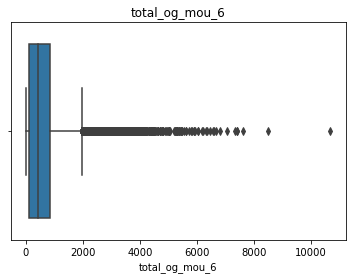

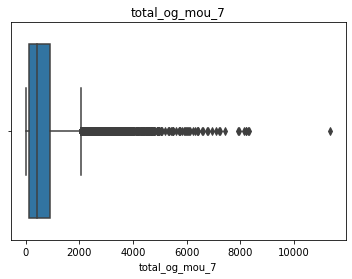

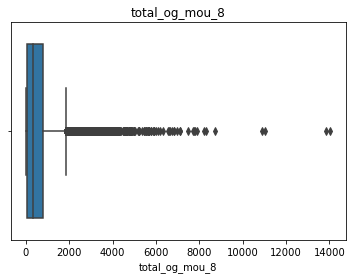

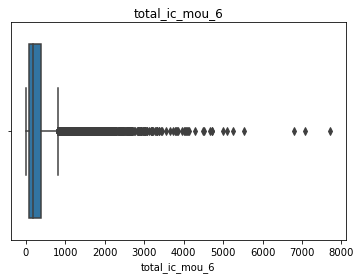

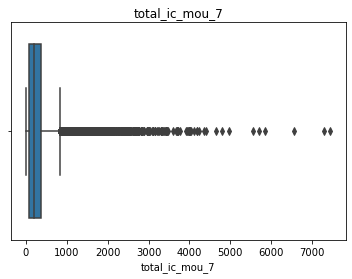

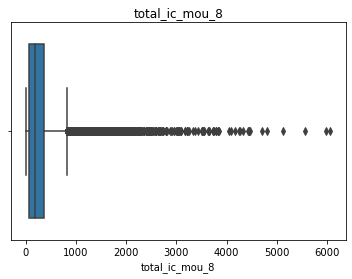

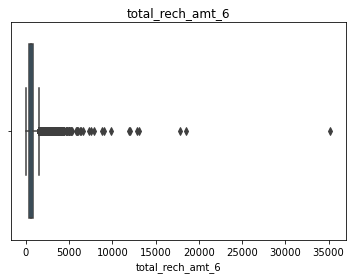

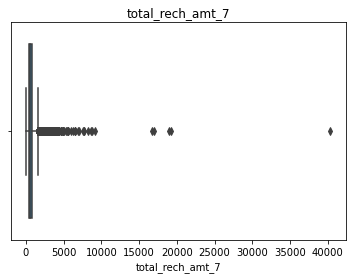

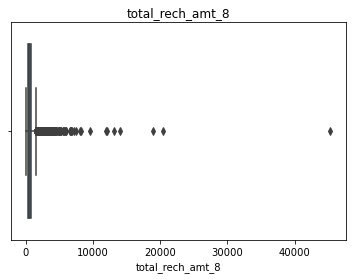

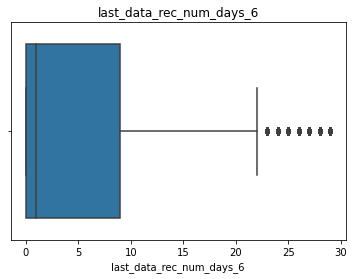

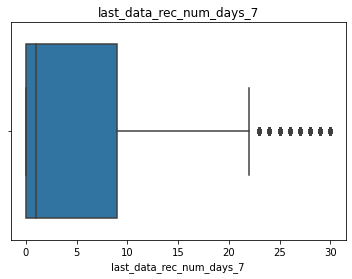

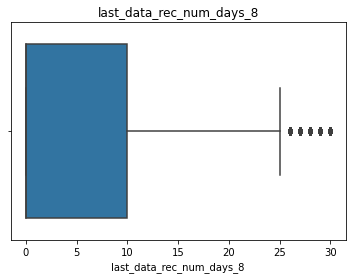

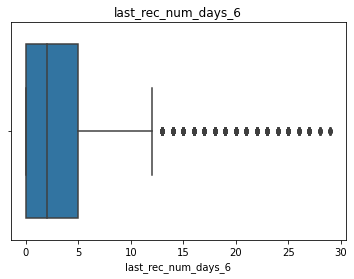

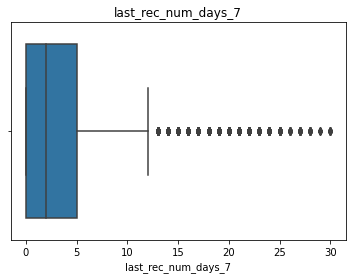

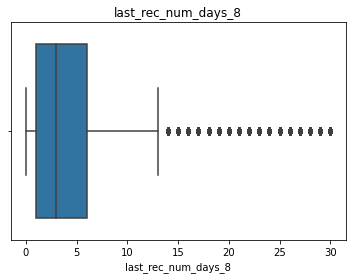

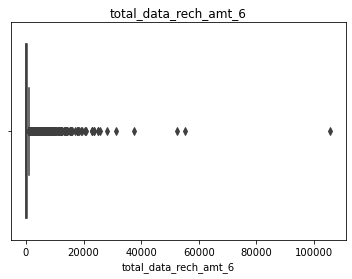

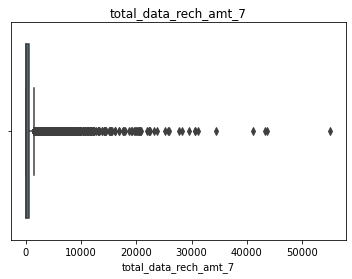

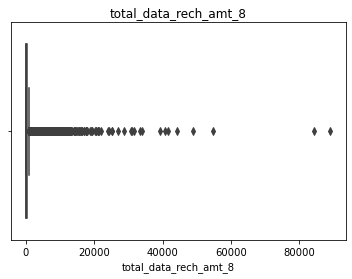

In [51]:
def box_plot_uni(featu):
    for col in featu:
        sns.boxplot(pref_cust_df[col])
        plt.title(col)
        plt.show()
box_plot_uni(features)

**OUTLIERS**
- total_og_mou_6, total_og_mou_7, total_og_mou_8: remove outliers after 8k


- total_ic_mou_6, total_ic_mou_7, total_ic_mou_8: remove outliers after 5000


- total_rech_amt_6, total_rech_amt_7, total_rech_amt_8: remove outliers after 10k


- total_data_rech_amt_6, total_data_rech_amt_7, total_data_rech_amt_8: remove outliers after 20k

In [52]:
# removing outliers
pref_cust_df = pref_cust_df[~((pref_cust_df['total_og_mou_6'] >= 8000) | (pref_cust_df['total_og_mou_7'] >= 8000) | (pref_cust_df['total_og_mou_8'] >= 8000) | 
      (pref_cust_df['total_ic_mou_6'] >= 5000) | (pref_cust_df['total_ic_mou_7'] >= 5000) | (pref_cust_df['total_ic_mou_8'] >= 5000) |
     (pref_cust_df['total_rech_amt_6'] >= 10000) | (pref_cust_df['total_rech_amt_7'] >= 10000) | (pref_cust_df['total_rech_amt_8'] >= 10000) |
     (pref_cust_df['total_data_rech_amt_6'] >= 20000) | (pref_cust_df['total_data_rech_amt_7'] >= 20000) | (pref_cust_df['total_data_rech_amt_8'] >= 20000))]

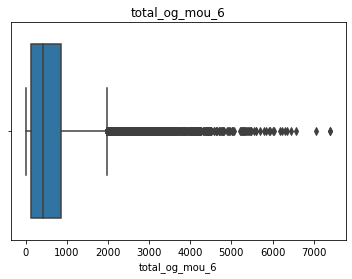

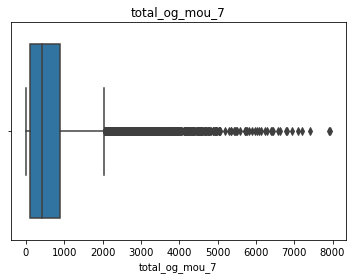

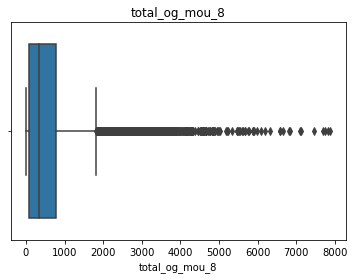

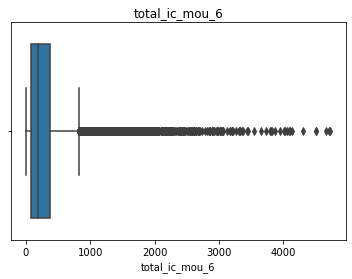

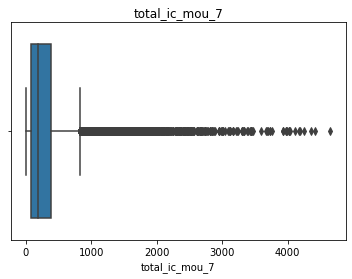

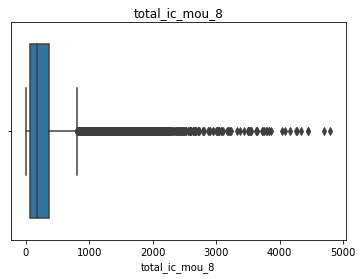

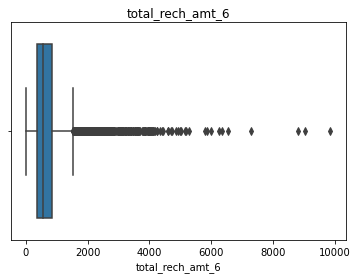

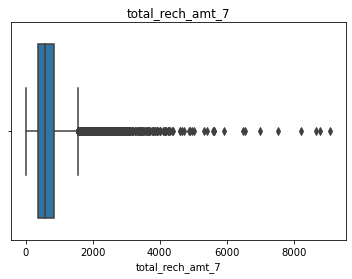

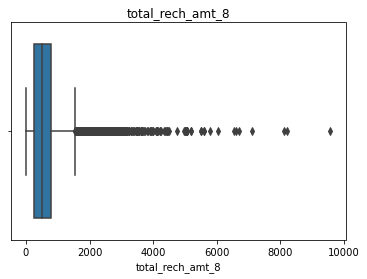

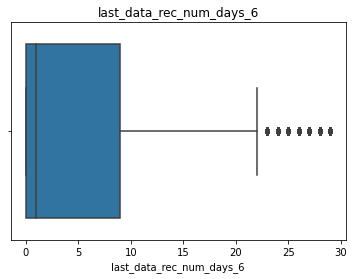

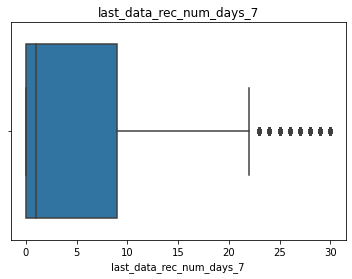

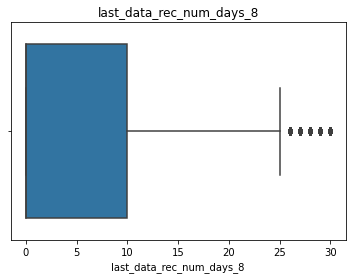

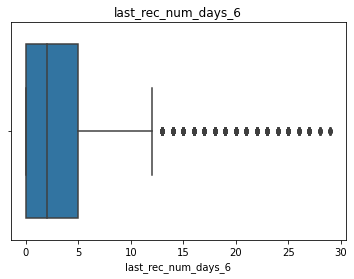

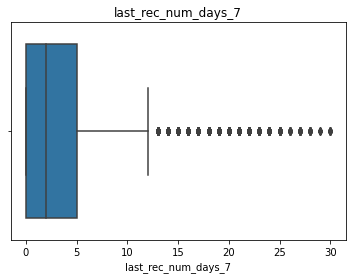

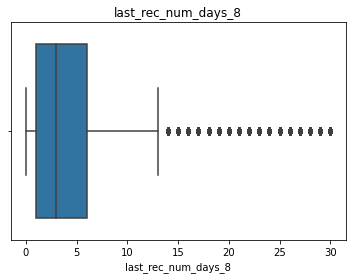

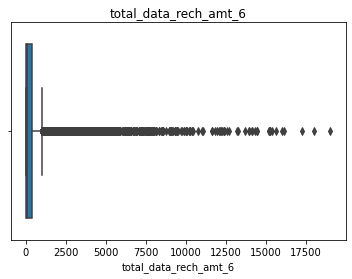

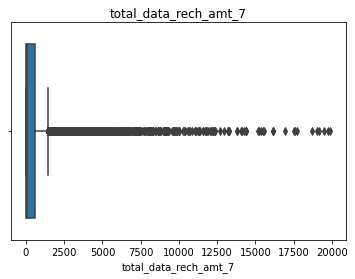

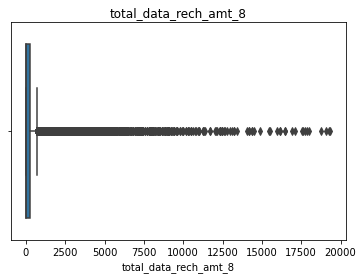

In [53]:
# check the distribution again
box_plot_uni(features)

#### Bivariate Analysis

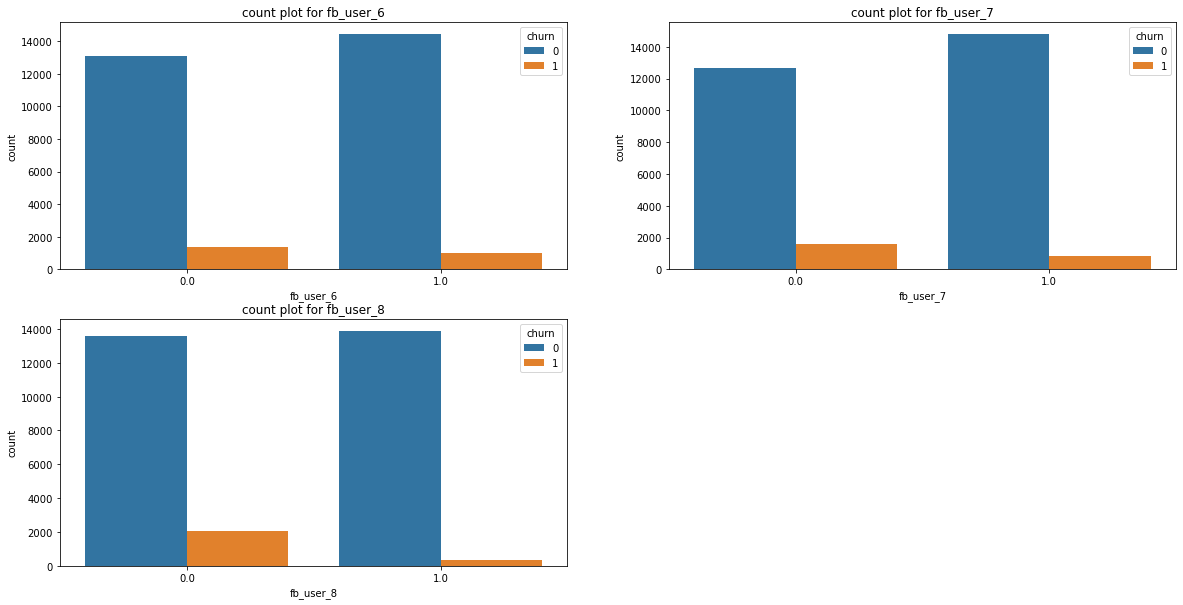

In [54]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.countplot(x = pref_cust_df.fb_user_6, hue = pref_cust_df.churn)
plt.title('count plot for fb_user_6')
plt.subplot(2,2,2)
sns.countplot(x = pref_cust_df.fb_user_7, hue = pref_cust_df.churn)
plt.title('count plot for fb_user_7')
plt.subplot(2,2,3)
sns.countplot(x = pref_cust_df.fb_user_8, hue = pref_cust_df.churn)
plt.title('count plot for fb_user_8')
plt.show()

We can observe a dip in fb users from good phase to action phase for the curned cases

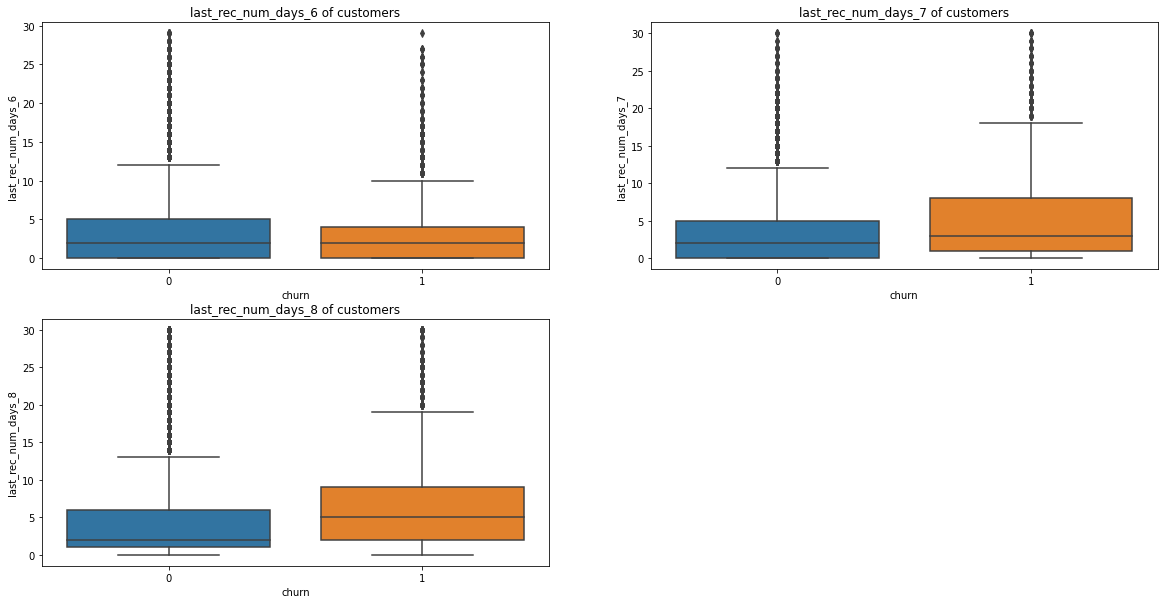

In [55]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.boxplot(y = 'last_rec_num_days_6',x ='churn', data =pref_cust_df)
plt.title('last_rec_num_days_6 of customers')

plt.subplot(2,2,2)
sns.boxplot(y = 'last_rec_num_days_7', x ='churn', data =pref_cust_df)
plt.title('last_rec_num_days_7 of customers')

plt.subplot(2,2,3)
sns.boxplot(y = 'last_rec_num_days_8', x = 'churn',data =pref_cust_df)
plt.title('last_rec_num_days_8 of customers')
plt.show()

There is a gradual change in recency of recharge as we move form good to action phase

#### Train Test split
- Perform outlier treatment on train and test separately

In [56]:
train, test = train_test_split(pref_cust_df, train_size = 0.7, test_size = 0.3, random_state = 40)
# check the class imbalance in train and test data
print('rate of churned customers in train:', 100*(len(train[train.churn==1])/len(train)), '\n',
      'rate of churned customers in test:', 100*(len(test[test.churn==1])/len(test)))

rate of churned customers in train: 8.339303625161198 
 rate of churned customers in test: 7.656302240053494


**Segregate target and independent variables**

In [57]:
X_train = train.drop('churn', axis= 1)
y_train = train['churn']
X_test = test.drop('churn', axis =1)
y_test = test['churn']

**Scale the data**

In [58]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

### PCA
Perform dimensionality reduction with explained variance ratio 95%

In [59]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
pca.n_components_

73

73 principal components are needed to explain 95% variance in the data

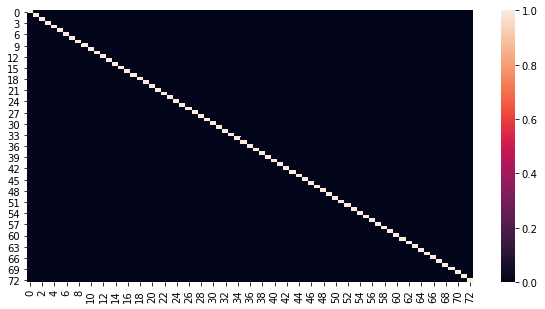

In [60]:
# check the correlation of PCs
plt.figure(figsize = (10,5))
corrmat = np.corrcoef(X_train_pca.transpose())
sns.heatmap(corrmat)

73 PCs are derived to represent 95% of data and all of them are uncorrelated

#### Build a logistic regression model

In [61]:
# build logit with PCA features
logit = LogisticRegression(class_weight = 'balanced')
logit.fit(X_train_pca, y_train)

# predict probabilities and calculate auc
pca_pred_prob_train = logit.predict_proba(X_train_pca)[:,1]
pca_pred_prob_test = logit.predict_proba(X_test_pca)[:,1]
pca_auc_score_train = roc_auc_score(y_train, pca_pred_prob_train)
pca_auc_score_test = roc_auc_score(y_test, pca_pred_prob_test)
print('auc for train: ',pca_auc_score_train, '\n','auc for test: ',pca_auc_score_test)

auc for train:  0.8945660381683066 
 auc for test:  0.8996655588897778


#### Build another PCA to see the no. of components needed to explain 90% of data and check reduction in performance

In [62]:
pca_2 = PCA(0.9)
X_train_pca_2 = pca_2.fit_transform(X_train_scaled)
X_test_pca_2 = pca_2.transform(X_test_scaled)
pca_2.n_components_

55

number of components became 55 from 73 for 5% drop in explained variance

### Modelling:

### Model 1: Logistic Regression:

In [63]:
# build logistic regression model and check performance
logit_2 = LogisticRegression(class_weight = 'balanced')
logit_2.fit(X_train_pca_2,y_train)

pca2_pred_prob_train = logit_2.predict_proba(X_train_pca_2)[:,1]
pca2_pred_prob_test = logit_2.predict_proba(X_test_pca_2)[:,1]
churn_test = pd.DataFrame({'churn': y_test.values,'predicted_proba':pca2_pred_prob_test})
churn_train = pd.DataFrame({'churn': y_train.values,'predicted_proba':pca2_pred_prob_train})
pca2_auc_score_train = roc_auc_score(y_train, pca2_pred_prob_train)
pca2_auc_score_test = roc_auc_score(y_test, pca2_pred_prob_test)
print('auc for train: ',pca2_auc_score_train, '\n','auc for test: ',pca2_auc_score_test)

auc for train:  0.890183674179555 
 auc for test:  0.8983524234244396


- Drop in performance in terms of auc is considerably low. Hence, using 55 components is also okay.
- check accuracy, specificity and sensitivity trade-off an identify a suitable cut-off probability

In [64]:
# identify appropriate cut off threshold and calculate performance metrics
def accu_sens_speci(dataframe):
    num = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        dataframe[i]= dataframe.predicted_proba.map(lambda x: 1 if x > i else 0)
    
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

    for i in num:
        cm1 = metrics.confusion_matrix(dataframe.churn, dataframe[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
    
        specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
# Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='probability', y=['accuracy','sensitivity','specificity'])
    print(cutoff_df)
    plt.show()

In [65]:
# define a function to generate performance metrics
def perf_metrics(conf_matrix_train,conf_matrix_test):
    # metrics for train
    sensitivity_train = round(conf_matrix_train[1,1]/(conf_matrix_train[1,1]+conf_matrix_train[1,0]),3)
    specificity_train = round(conf_matrix_train[0,0]/(conf_matrix_train[0,0]+conf_matrix_train[0,1]),3)
    accuracy_train = round(accuracy_score(churn_train.churn,churn_train.predicted_labels),3)
    FPR_train = round(conf_matrix_train[0,1]/(conf_matrix_train[0,0]+conf_matrix_train[0,1]),3)
        
    # metrics for test data
    sensitivity_test = round(conf_matrix_test[1,1]/(conf_matrix_test[1,1]+conf_matrix_test[1,0]),3)
    specificity_test = round(conf_matrix_test[0,0]/(conf_matrix_test[0,0]+conf_matrix_test[0,1]),3)
    accuracy_test = round(accuracy_score(churn_test.churn,churn_test.predicted_labels),3)
    FPR_test = round(conf_matrix_test[0,1]/(conf_matrix_test[0,0]+conf_matrix_test[0,1]),3)
       
    # combined dataframe for performance metrics
    perf_params = pd.DataFrame(columns=['accuracy','sensitivity','sepcificity','FPR'], index = ['train','test'])
    perf_params.loc['train',:] = [accuracy_train,sensitivity_train,specificity_train,FPR_train]
    perf_params.loc['test',:] = [accuracy_test,sensitivity_test,specificity_test,FPR_test]
    return (perf_params)

     probability  accuracy  sensitivity  specificity
0.0          0.0  0.083393     1.000000     0.000000
0.1          0.1  0.382911     0.971936     0.329321
0.2          0.2  0.543153     0.948454     0.506279
0.3          0.3  0.662702     0.920962     0.639206
0.4          0.4  0.750155     0.878007     0.738523
0.5          0.5  0.818169     0.837915     0.816372
0.6          0.6  0.865119     0.781214     0.872753
0.7          0.7  0.896212     0.683276     0.915585
0.8          0.8  0.917419     0.529210     0.952738
0.9          0.9  0.920953     0.248568     0.982127


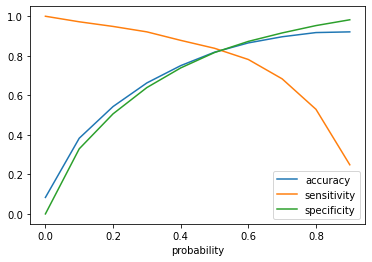

In [66]:
accu_sens_speci(churn_train)

choose between 0.4 - 0.5 as the cut-off probability to have good sensitivity and accuracy

##### cut-off probability = 0.4

In [67]:
# cut-off probability = 0.4
churn_test['predicted_labels'] = churn_test['predicted_proba'].apply(lambda x: 0 if x<=0.4 else 1)
churn_train['predicted_labels'] = churn_train['predicted_proba'].apply(lambda x: 0 if x<=0.4 else 1)

# check classification report
pd.DataFrame(classification_report(churn_test.churn, churn_test.predicted_labels, output_dict  =True))

,0,1,accuracy,macro avg,weighted avg
precision,0.988592,0.217483,0.74479,0.603038,0.929554
recall,0.732078,0.898108,0.74479,0.815093,0.744790
f1-score,0.841215,0.350170,0.74479,0.595693,0.803619
support,8286.000000,687.000000,0.74479,8973.000000,8973.000000


In [68]:
# check confusion matrix
conf_matrix_train = confusion_matrix(churn_train.churn, churn_train.predicted_labels)
conf_matrix_test = confusion_matrix(churn_test.churn, churn_test.predicted_labels)

#calculate model performance parameters and create a dataframe for it
model_metrics = perf_metrics(conf_matrix_train,conf_matrix_test).reset_index(drop = False).rename(columns = {'index':'dataset'})
model_metrics.loc[:,'model_type'] = 'LR Model1_0.4'
model_metrics.set_index(keys = ['model_type','dataset'], inplace=True)

##### cut-off probability = 0.45

In [69]:
# cut-off probability = 0.45
churn_test['predicted_labels'] = churn_test['predicted_proba'].apply(lambda x: 0 if x<=0.45 else 1)
churn_train['predicted_labels'] = churn_train['predicted_proba'].apply(lambda x: 0 if x<=0.45 else 1)

# check classification report
pd.DataFrame(classification_report(churn_test.churn, churn_test.predicted_labels, output_dict  =True))

,0,1,accuracy,macro avg,weighted avg
precision,0.986484,0.243298,0.78257,0.614891,0.929584
recall,0.775163,0.871907,0.78257,0.823535,0.782570
f1-score,0.868149,0.380438,0.78257,0.624294,0.830808
support,8286.000000,687.000000,0.78257,8973.000000,8973.000000


In [70]:
# check confusion matrix
conf_matrix_train = confusion_matrix(churn_train.churn, churn_train.predicted_labels)
conf_matrix_test = confusion_matrix(churn_test.churn, churn_test.predicted_labels)

#calculate model performance parameters and add details to the common dataframe
loc_perf = perf_metrics(conf_matrix_train,conf_matrix_test)
model_metrics.loc[('LR Model1_0.45','train'),:] = loc_perf[:1].values[-1]
model_metrics.loc[('LR Model1_0.45','test'),:] = loc_perf[1:2].values[-1]
model_metrics

accuracy sensitivity sepcificity    FPR
model_type     dataset                                        
LR Model1_0.4  train       0.75       0.878       0.739  0.261
               test       0.745       0.898       0.732  0.268
LR Model1_0.45 train      0.786       0.859       0.779  0.221
               test       0.783       0.872       0.775  0.225

### Model 2: Hyper-paramter tuned Logistic Regression on Train Dataset with 73 principal components:

In [71]:
params =  {'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]}

lr = LogisticRegression(class_weight = 'balanced')
clf_lr = GridSearchCV(lr, params, verbose=10, cv=5 ,n_jobs=-1,scoring='roc_auc',return_train_score=True)

In [72]:
clf_lr.fit(X_train_pca, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  46 out of  55 | elapsed:    5.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  52 out of  55 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    5.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000]},
             return_train_score=True, scoring='roc_auc', verbose=10)

In [73]:
clf_lr.best_params_

{'C': 0.01}

In [74]:
cv_df = pd.DataFrame(data = clf_lr.cv_results_)
cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.205795,0.032601,0.006782,0.003534,1e-05,{'C': 1e-05},0.862025,0.845140,0.845462,0.861458,...,0.853841,0.007383,11,0.852993,0.858119,0.857925,0.855742,0.857256,0.856407,0.001900
1,0.228318,0.009585,0.009241,0.005891,0.0001,{'C': 0.0001},0.880949,0.865476,0.868866,0.880036,...,0.873609,0.006076,10,0.874296,0.878552,0.877614,0.876788,0.878878,0.877226,0.001638
2,0.341623,0.014637,0.010704,0.003439,0.001,{'C': 0.001},0.892437,0.877855,0.883096,0.887308,...,0.884703,0.004892,9,0.887149,0.891709,0.890774,0.890099,0.893398,0.890626,0.002061
3,0.499014,0.029387,0.007646,0.006995,0.01,{'C': 0.01},0.895687,0.880871,0.885852,0.887765,...,0.886556,0.005162,1,0.890933,0.895551,0.894743,0.894044,0.898515,0.894758,0.002445
4,0.577579,0.039782,0.009374,0.007653,0.1,{'C': 0.1},0.896485,0.880604,0.885803,0.887394,...,0.886442,0.005598,2,0.891422,0.896026,0.895235,0.894538,0.899263,0.895297,0.002524


**Printing the AUCs to check model performance:**

Lambda Log-Lambda
1e-05 -11.512925464970229
0.0001 -9.210340371976182
0.001 -6.907755278982137
0.01 -4.605170185988091
0.1 -2.3025850929940455
1 0.0
10 2.302585092994046
100 4.605170185988092
1000 6.907755278982137
10000 9.210340371976184
100000 11.512925464970229


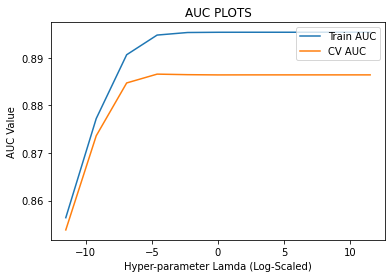

In [75]:
import math
alpha = []
print('Lambda','Log-Lambda')
for n in range(len(cv_df.param_C)):
    alpha1 = cv_df.param_C[n]
    x = math.log(alpha1)
    print(alpha1,x)
    alpha.append(x)

plt.plot(alpha,cv_df.mean_train_score)
plt.plot(alpha,cv_df.mean_test_score)
plt.legend(['Train AUC','CV AUC'], loc='upper right')
plt.title("AUC PLOTS")
plt.xlabel('Hyper-parameter Lamda (Log-Scaled)')
plt.ylabel('AUC Value')
plt.show()

We can see that with increase in C value, there is slight overfitting in the model. 

So, we are going to use **C=0.01 corresponding to -4.60 in the plot**.

In [76]:
best_logreg = LogisticRegression(C = 0.01,class_weight = 'balanced')
best_logreg.fit(X_train_pca, y_train)

predicted_labels_train = best_logreg.predict(X_train_pca)
predict_train_prob = best_logreg.predict_proba(X_train_pca)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train, predict_train_prob)

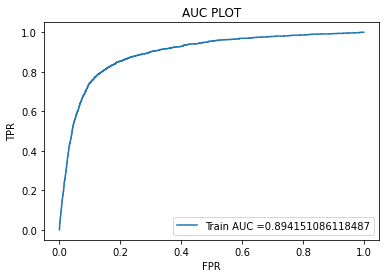

In [77]:
# Plotting the AUC curve on Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOT")
plt.show()

Train Confusion Matrix


Text(0.5, 1.0, 'Confusion Matrix of Train Data')

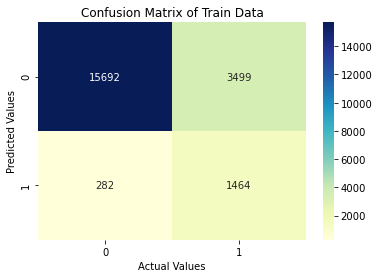

In [78]:
print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(y_train,predicted_labels_train).ravel()
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

**Changing the decision boundary to improve sensitivity metric.**

In [79]:
LR_train = pd.DataFrame()
LR_train['churn'] = train['churn']
LR_train['predicted_labels'] = predicted_labels_train
LR_train['predicted_proba'] = predict_train_prob
LR_train.head()

,churn,predicted_labels,predicted_proba
6001,0,0,0.396224
11801,0,0,0.333484
25425,0,0,0.170839
5812,0,0,0.471813
13131,0,0,0.358609


     probability  accuracy  sensitivity  specificity
0.0          0.0  0.083393     1.000000     0.000000
0.1          0.1  0.384391     0.975945     0.330572
0.2          0.2  0.544443     0.953608     0.507217
0.3          0.3  0.662129     0.919244     0.638737
0.4          0.4  0.750537     0.886025     0.738211
0.5          0.5  0.819411     0.838488     0.817675
0.6          0.6  0.867698     0.783505     0.875358
0.7          0.7  0.898505     0.686712     0.917774
0.8          0.8  0.919282     0.528637     0.954823
0.9          0.9  0.921765     0.236541     0.984107


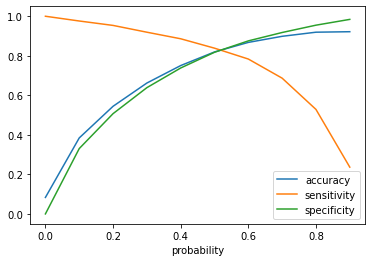

In [80]:
# Plotting accuracy, sensitivity, and specificity for various probabilities.
accu_sens_speci(LR_train)

Decision boundary between 0.4 and 0.5 will perform good for all the metrics.

In [81]:
LR_train['final_predicted'] = LR_train.predicted_proba.map( lambda x: 1 if x > 0.4 else 0)
LR_train.head()

,churn,predicted_labels,predicted_proba,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
6001,0,0,0.396224,1,1,1,1,0,0,0,0,0,0,0
11801,0,0,0.333484,1,1,1,1,0,0,0,0,0,0,0
25425,0,0,0.170839,1,1,0,0,0,0,0,0,0,0,0
5812,0,0,0.471813,1,1,1,1,1,0,0,0,0,0,1
13131,0,0,0.358609,1,1,1,1,0,0,0,0,0,0,0


In [82]:
confusion2 = metrics.confusion_matrix(LR_train.churn, LR_train.final_predicted )
conf_train = confusion2.copy()
confusion2

array([[14167,  5024],
       [  199,  1547]], dtype=int64)

Train Confusion Matrix after thresholding


Text(0.5, 1.0, 'Confusion Matrix of Train Data')

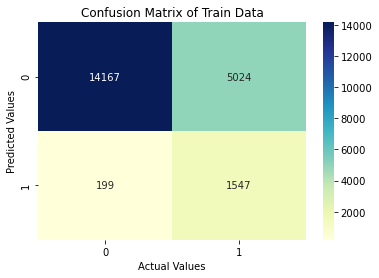

In [83]:
print('Train Confusion Matrix after thresholding')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(LR_train.churn, LR_train.final_predicted).ravel()
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

In [84]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [85]:
# Let's check the overall accuracy.
lr_train_accuracy = metrics.accuracy_score(LR_train.churn, LR_train.final_predicted)
print('Train Accuracy : ', lr_train_accuracy)
# Let's see the sensitivity of our logistic regression model
lr_train_sensitivity = TP / float(TP+FN)
print('Train Sensitivity: ',lr_train_sensitivity)
# Let us calculate specificity
lr_train_specificity = TN / float(TN+FP)
print('Train Specificity : ',lr_train_specificity)
# Calculate false postive rate - predicting churn when customer does not have churned
lr_train_frp = FP/ float(TN+FP)
print('Train False Positive Rate : ', lr_train_frp)

Train Accuracy :  0.7505373262645078
Train Sensitivity:  0.8860252004581901
Train Specificity :  0.7382106195612527
Train False Positive Rate :  0.26178938043874733


In [86]:
print("Train Precision : ", precision_score(LR_train.churn, LR_train.final_predicted))
print("Train Recall : ", recall_score(LR_train.churn, LR_train.final_predicted))

Train Precision :  0.23542839750418507
Train Recall :  0.8860252004581901


### Using LR on Test Dataset

In [87]:
predicted_labels_test = best_logreg.predict(X_test_pca)
predict_test_prob = best_logreg.predict_proba(X_test_pca)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_test_prob)

In [88]:
# Converting y_pred to a dataframe which is an array
LR_test = pd.DataFrame()
LR_test['actual_label']=y_test
LR_test['predicted_labels']=predicted_labels_test
LR_test['predicted_prob'] = predict_test_prob
LR_test.head()

,actual_label,predicted_labels,predicted_prob
5133,0,0,0.000032
26545,0,0,0.424520
4956,0,0,0.425030
161,0,0,0.346797
8148,0,0,0.054060


In [89]:
LR_test['final_predicted'] = LR_test.predicted_prob.map(lambda x: 1 if x > 0.4 else 0)

In [90]:
LR_test.head()

,actual_label,predicted_labels,predicted_prob,final_predicted
5133,0,0,0.000032,0
26545,0,0,0.424520,1
4956,0,0,0.425030,1
161,0,0,0.346797,0
8148,0,0,0.054060,0


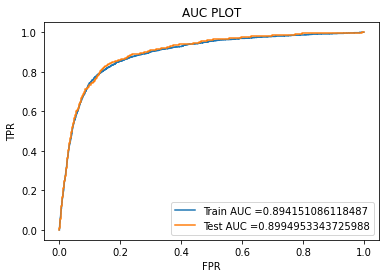

In [91]:
# Plotting the AUC curve on Train and Test Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOT")
plt.show()

In [92]:
confusion2 = metrics.confusion_matrix(LR_test.actual_label, LR_test.final_predicted )
confusion2

array([[6069, 2217],
       [  73,  614]], dtype=int64)

In [93]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [94]:
# Let's check the overall accuracy.
lr_test_accuracy = metrics.accuracy_score(LR_test.actual_label, LR_test.final_predicted)
print('Test Accuracy : ', lr_test_accuracy)
# Let's see the sensitivity of our logistic regression model
lr_test_sensitivity = TP / float(TP+FN)
print("Test Sensitivity : ", lr_test_sensitivity)
# Let us calculate specificity
lr_test_specificity = TN / float(TN+FP)
print("Test Specificity : ", lr_test_specificity)
lr_test_frp = FP/ float(TN+FP)
print('Test False Positive Rate : ', lr_test_frp)

Test Accuracy :  0.7447899253315502
Test Sensitivity :  0.893740902474527
Test Specificity :  0.7324402606806661
Test False Positive Rate :  0.2675597393193338


In [95]:
print("Test Precision : ", precision_score(LR_test.actual_label, LR_test.final_predicted))
print("Test Recall : ", recall_score(LR_test.actual_label, LR_test.final_predicted))

Test Precision :  0.21688449311197458
Test Recall :  0.893740902474527


In [96]:
#calculate model performance parameters and add details to the common dataframe
churn_train = LR_train.copy()
churn_test = LR_test.copy()
churn_train.drop('predicted_labels', axis = 1, inplace = True)
churn_test.drop('predicted_labels', axis = 1, inplace = True)
churn_train.rename(columns = {'final_predicted':'predicted_labels'}, inplace =True)
churn_test.rename(columns = {'final_predicted':'predicted_labels','actual_label':'churn'}, inplace =True)

loc_perf = perf_metrics(conf_train,confusion2)
model_metrics.loc[('LR Model2_0.4','train'),:] = loc_perf[:1].values[-1]
model_metrics.loc[('LR Model2_0.4','test'),:] = loc_perf[1:2].values[-1]

In [97]:
model_metrics

accuracy sensitivity sepcificity    FPR
model_type     dataset                                        
LR Model1_0.4  train       0.75       0.878       0.739  0.261
               test       0.745       0.898       0.732  0.268
LR Model1_0.45 train      0.786       0.859       0.779  0.221
               test       0.783       0.872       0.775  0.225
LR Model2_0.4  train      0.751       0.886       0.738  0.262
               test       0.745       0.894       0.732  0.268

### Model 3: Tree model
##### Build a decision tree with principal components identified using PCA

In [98]:
# identify suitable hyperparameters
dt_pca_gs = DecisionTreeClassifier(random_state=42, criterion='gini', class_weight= 'balanced')
params = {'max_depth':[3,4,6,8,10,15,20], 'min_samples_leaf': [20,30,50,70,80,100]}
grid_serach_dt = GridSearchCV(dt_pca_gs, param_grid=params,n_jobs = -1, cv = 5, scoring = 'recall')
grid_serach_dt.fit(X_train_pca_2, y_train)
print(grid_serach_dt.best_params_)
pd.DataFrame(grid_serach_dt.cv_results_)

{'max_depth': 8, 'min_samples_leaf': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.479203,0.003678,0.003125,0.006250,3,20,"{'max_depth': 3, 'min_samples_leaf': 20}",0.696275,0.620000,0.618911,0.684814,0.710602,0.666120,0.038970,34
1,0.491211,0.012647,0.002193,0.002705,3,30,"{'max_depth': 3, 'min_samples_leaf': 30}",0.696275,0.620000,0.618911,0.684814,0.710602,0.666120,0.038970,34
2,0.514022,0.016571,0.006184,0.000975,3,50,"{'max_depth': 3, 'min_samples_leaf': 50}",0.696275,0.620000,0.618911,0.684814,0.710602,0.666120,0.038970,34
3,0.482588,0.008563,0.010572,0.006472,3,70,"{'max_depth': 3, 'min_samples_leaf': 70}",0.696275,0.620000,0.618911,0.684814,0.710602,0.666120,0.038970,34
4,0.477900,0.005432,0.006249,0.007654,3,80,"{'max_depth': 3, 'min_samples_leaf': 80}",0.696275,0.620000,0.618911,0.684814,0.710602,0.666120,0.038970,34
5,0.478009,0.007653,0.003124,0.006249,3,100,"{'max_depth': 3, 'min_samples_leaf': 100}",0.696275,0.620000,0.618911,0.684814,0.710602,0.666120,0.038970,34
6,0.643596,0.018219,0.003125,0.006250,4,20,"{'max_depth': 4, 'min_samples_leaf': 20}",0.742120,0.722857,0.739255,0.756447,0.687679,0.729672,0.023552,19
7,0.681089,0.025382,0.000000,0.000000,4,30,"{'max_depth': 4, 'min_samples_leaf': 30}",0.742120,0.722857,0.739255,0.759312,0.687679,0.730245,0.024222,17
8,0.830607,0.006250,0.006248,0.007652,4,50,"{'max_depth': 4, 'min_samples_leaf': 50}",0.742120,0.731429,0.739255,0.759312,0.687679,0.731959,0.023940,14
9,0.848099,0.013735,0.006249,0.007653,4,70,"{'max_depth': 4, 'min_samples_leaf': 70}",0.742120,0.731429,0.739255,0.759312,0.687679,0.731959,0.023940,14


In [99]:
# build a decision tree with the identified parameters from hyperparameter tuning
dt_pca = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth = 8, min_samples_leaf = 100, class_weight='balanced')
dt_pca.fit(X_train_pca_2,y_train)
dt_pred_churn_train = dt_pca.predict(X_train_pca_2)
dt_pred_churn_test = dt_pca.predict(X_test_pca_2)
churn_train = pd.DataFrame({'churn':y_train.values, 'predicted_labels':dt_pred_churn_train})
churn_test = pd.DataFrame({'churn':y_test.values,'predicted_labels':dt_pred_churn_test})

# check confusion mertics and other performance mertics
conf_matrix_train = confusion_matrix(churn_train.churn, churn_train.predicted_labels)
conf_matrix_test = confusion_matrix(churn_test.churn, churn_test.predicted_labels)
loc_perf = perf_metrics(conf_matrix_train,conf_matrix_test)

#calculate model performance parameters and add details to the common dataframe
model_metrics.loc[('DT Model','train'),:] = loc_perf[:1].values[-1]
model_metrics.loc[('DT Model','test'),:] = loc_perf[1:2].values[-1]

##### check for a different set of hyperparameters
### Model 4: Tree model with different set of hyper parameters

In [100]:
# identify suitable hyperparameters
dt_pca_gs = DecisionTreeClassifier(random_state=42, criterion='gini')
params = {'max_depth':[3,4,6,8,10,15,20], 'min_samples_leaf': [20,30,50,70,80,100], 'class_weight':[{0:0.5,1:0.5},{0:0.4,1:0.6},{0:0.3,1:0.7},{0:0.2,1:0.8}, {0:0.1,1:0.9}]}
grid_serach_dt = GridSearchCV(dt_pca_gs, param_grid=params,n_jobs = -1, cv = 5, scoring = 'recall')
grid_serach_dt.fit(X_train_pca_2, y_train)
grid_serach_dt.best_params_

{'class_weight': {0: 0.1, 1: 0.9}, 'max_depth': 10, 'min_samples_leaf': 80}

In [101]:
# build a decision tree with the identified parameters from hyperparameter tuning
dt_pca = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth = 10, min_samples_leaf = 80, class_weight= {0: 0.1, 1: 0.9})
dt_pca.fit(X_train_pca_2,y_train)
dt_pred_churn_train = dt_pca.predict(X_train_pca_2)
dt_pred_churn_test = dt_pca.predict(X_test_pca_2)
churn_train['predicted_labels'] = dt_pred_churn_train
churn_test['predicted_labels'] = dt_pred_churn_test

# check confusion mertics and other performance mertics
conf_matrix_train = confusion_matrix(churn_train.churn, churn_train.predicted_labels)
conf_matrix_test = confusion_matrix(churn_test.churn, churn_test.predicted_labels)
perf_metrics(conf_matrix_train,conf_matrix_test)

,accuracy,sensitivity,sepcificity,FPR
train,0.799,0.869,0.793,0.207
test,0.78,0.747,0.783,0.217


In [102]:
model_metrics

accuracy sensitivity sepcificity    FPR
model_type     dataset                                        
LR Model1_0.4  train       0.75       0.878       0.739  0.261
               test       0.745       0.898       0.732  0.268
LR Model1_0.45 train      0.786       0.859       0.779  0.221
               test       0.783       0.872       0.775  0.225
LR Model2_0.4  train      0.751       0.886       0.738  0.262
               test       0.745       0.894       0.732  0.268
DT Model       train      0.794       0.848        0.79   0.21
               test       0.775       0.745       0.778  0.222

First tree model is comparatively better than the last tree model.

### Model 5: Random Forest On Train Dataset

In [103]:
tuned_param = [{'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
               'n_estimators':[5, 10, 50, 100, 200, 500, 1000]
               }]

In [104]:
# Using GridSearchCV
rf_model = GridSearchCV(RandomForestClassifier(class_weight={0:0.1, 1: 0.9},max_features = 'auto', random_state = 0, n_jobs = -1),
                        tuned_param,cv = 5, verbose = 1, scoring = 'roc_auc')
rf_model.fit(X_train_pca, y_train)

print(rf_model.best_estimator_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 23.7min finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=10,
                       n_estimators=1000, n_jobs=-1, random_state=0)


In [105]:
rf_cv_df = pd.DataFrame(data = rf_model.cv_results_)
rf_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.187681,0.022260,0.002593,0.005187,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.776822,0.784641,0.788100,0.767469,0.757432,0.774893,0.011253,63
1,0.247403,0.040513,0.000000,0.000000,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.806890,0.793644,0.799029,0.784460,0.786292,0.794063,0.008270,62
2,0.497170,0.018665,0.024978,0.007650,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.841619,0.833496,0.840960,0.841597,0.835845,0.838704,0.003384,52
3,0.786262,0.013205,0.043722,0.006256,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.855185,0.836771,0.847470,0.850980,0.841626,0.846407,0.006554,46
4,1.617144,0.149454,0.090569,0.011678,2,200,"{'max_depth': 2, 'n_estimators': 200}",0.855191,0.834825,0.844223,0.846347,0.840794,0.844276,0.006706,50


In [106]:
X_axis = np.array(rf_cv_df['param_n_estimators'], dtype=float)
Y_axis = np.array(rf_cv_df['param_max_depth'], dtype=float)

Text(0.5, 1.0, 'Train AUC HeatMap')

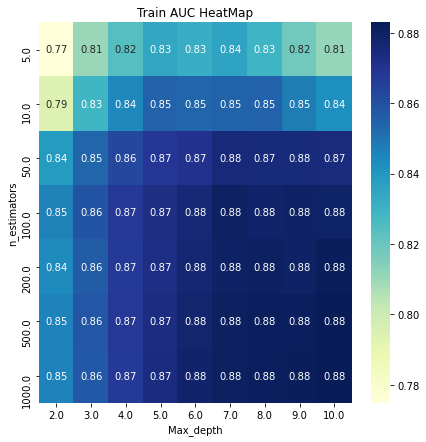

In [107]:
pvt_test = pd.pivot_table(pd.DataFrame(rf_cv_df),values='mean_test_score', index=X_axis, columns=Y_axis)
plt.figure(figsize=(7,7))
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('Train AUC HeatMap')

**Choosing max_depth=6 and n_estimators=100 to get best AUC with less complex model.**

In [108]:
best_rf = RandomForestClassifier(class_weight = 'balanced',max_depth = 6,n_estimators=100, random_state=0)
best_rf.fit(X_train_pca, y_train)

predicted_labels_train = best_rf.predict(X_train_pca)
predict_train_prob = best_rf.predict_proba(X_train_pca)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train, predict_train_prob)

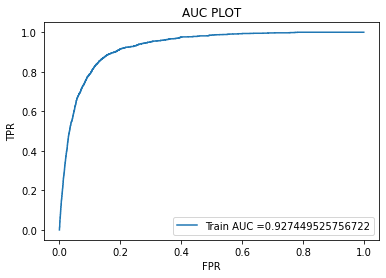

In [109]:
# Plotting the AUC curve on Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOT")
plt.show()

Train Confusion Matrix


Text(0.5, 1.0, 'Confusion Matrix of Train Data')

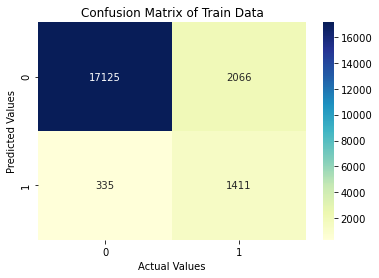

In [110]:
print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(y_train,predicted_labels_train).ravel()
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

In [111]:
confusion2 = metrics.confusion_matrix(y_train,predicted_labels_train )
confusion2

array([[17125,  2066],
       [  335,  1411]], dtype=int64)

In [112]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [113]:
# Let's check the overall accuracy.
rf_train_accuracy = metrics.accuracy_score(y_train,predicted_labels_train)
print('Train Accuracy : ', rf_train_accuracy)
# Let's see the sensitivity of our logistic regression model
rf_train_sensitivity = TP / float(TP+FN)
print('Train Sensitivity: ',rf_train_sensitivity)
# Let us calculate specificity
rf_train_specificity = TN / float(TN+FP)
print('Train Specificity : ',rf_train_specificity)
# Calculate false postive rate - predicting churn when customer does not have churned
rf_train_frp = FP/ float(TN+FP)
print('Train False Positive Rate : ', rf_train_frp)

Train Accuracy :  0.8853226345703779
Train Sensitivity:  0.8081328751431844
Train Specificity :  0.8923453702256265
Train False Positive Rate :  0.1076546297743734


**Changing the threshold to get better values of the metrics.**

In [114]:
RF_train = pd.DataFrame()
RF_train['churn'] = train['churn']
RF_train['predicted_labels'] = predicted_labels_train
RF_train['predicted_proba'] = predict_train_prob
RF_train.head()

,churn,predicted_labels,predicted_proba
6001,0,0,0.495139
11801,0,0,0.466786
25425,0,0,0.196189
5812,0,0,0.272415
13131,0,0,0.260105


     probability  accuracy  sensitivity  specificity
0.0          0.0  0.083393     1.000000     0.000000
0.1          0.1  0.083918     1.000000     0.000573
0.2          0.2  0.254382     1.000000     0.186546
0.3          0.3  0.583083     0.979381     0.547027
0.4          0.4  0.795147     0.922108     0.783596
0.5          0.5  0.885323     0.808133     0.892345
0.6          0.6  0.920141     0.654066     0.944349
0.7          0.7  0.928213     0.425544     0.973946
0.8          0.8  0.923198     0.155212     0.993070
0.9          0.9  0.916607     0.000000     1.000000


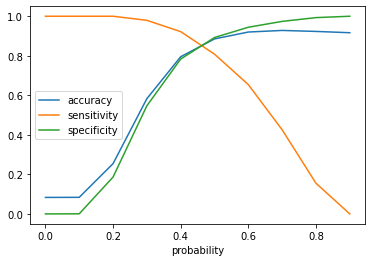

In [115]:
# Plotting accuracy sensitivity and specificity for various probabilities.
accu_sens_speci(RF_train)

Decision boundary between 0.4 and 0.5 should work well. 

Choosing 0.4 to boost sensitivity a little more.

In [116]:
RF_train['final_predicted'] = RF_train.predicted_proba.map( lambda x: 1 if x > 0.4 else 0)
RF_train.head()

,churn,predicted_labels,predicted_proba,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
6001,0,0,0.495139,1,1,1,1,1,0,0,0,0,0,1
11801,0,0,0.466786,1,1,1,1,1,0,0,0,0,0,1
25425,0,0,0.196189,1,1,0,0,0,0,0,0,0,0,0
5812,0,0,0.272415,1,1,1,0,0,0,0,0,0,0,0
13131,0,0,0.260105,1,1,1,0,0,0,0,0,0,0,0


Train Confusion Matrix after thresholding


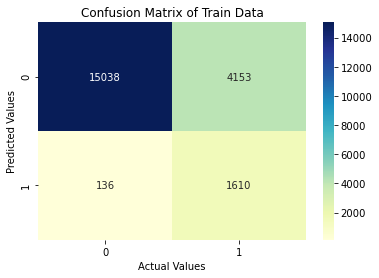

In [117]:
print('Train Confusion Matrix after thresholding')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(RF_train.churn, RF_train.final_predicted).ravel()
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')
plt.show()

In [118]:
confusion2 = metrics.confusion_matrix(RF_train.churn, RF_train.final_predicted)
conf_train = confusion2.copy()
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [119]:
# Let's check the overall accuracy.
rf_train_accuracy = metrics.accuracy_score(RF_train.churn, RF_train.final_predicted)
print('Train Accuracy : ', rf_train_accuracy)
# Let's see the sensitivity of our logistic regression model
rf_train_sensitivity = TP / float(TP+FN)
print('Train Sensitivity: ',rf_train_sensitivity)
# Let us calculate specificity
rf_train_specificity = TN / float(TN+FP)
print('Train Specificity : ',rf_train_specificity)
# Calculate false postive rate - predicting churn when customer does not have churned
rf_train_frp = FP/ float(TN+FP)
print('Train False Positive Rate : ', rf_train_frp)

Train Accuracy :  0.7951473468023117
Train Sensitivity:  0.9221076746849943
Train Specificity :  0.7835964775155021
Train False Positive Rate :  0.21640352248449793


In [120]:
print("Train Precision : ", precision_score(RF_train.churn, RF_train.final_predicted))
print("Train Recall : ", recall_score(RF_train.churn, RF_train.final_predicted))

Train Precision :  0.2793683845219504
Train Recall :  0.9221076746849943


### Random Forest On Test Dataset

In [121]:
predicted_labels_test = best_rf.predict(X_test_pca)
predict_test_prob = best_rf.predict_proba(X_test_pca)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_test_prob)

In [122]:
# Converting y_pred to a dataframe which is an array
RF_test = pd.DataFrame()
RF_test['actual_label']=y_test
RF_test['predicted_labels']=predicted_labels_test
RF_test['predicted_prob'] = predict_test_prob
RF_test.head()

,actual_label,predicted_labels,predicted_prob
5133,0,0,0.310685
26545,0,0,0.321010
4956,0,0,0.417492
161,0,0,0.328328
8148,0,0,0.286711


In [123]:
RF_test['final_predicted'] = RF_test.predicted_prob.map(lambda x: 1 if x > 0.4 else 0)

In [124]:
RF_test.head()

,actual_label,predicted_labels,predicted_prob,final_predicted
5133,0,0,0.310685,0
26545,0,0,0.321010,0
4956,0,0,0.417492,1
161,0,0,0.328328,0
8148,0,0,0.286711,0


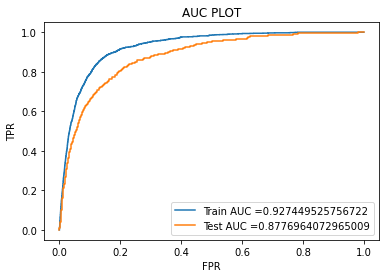

In [125]:
# Plotting the AUC curve on Train and Test Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOT")
plt.show()

In [126]:
confusion2 = metrics.confusion_matrix(RF_test.actual_label, RF_test.final_predicted )
confusion2

array([[6385, 1901],
       [ 112,  575]], dtype=int64)

In [127]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [128]:
# Let's check the overall accuracy.
rf_test_accuracy = metrics.accuracy_score(RF_test.actual_label, RF_test.final_predicted)
print('Test Accuracy : ', rf_test_accuracy)
# Let's see the sensitivity of our logistic regression model
rf_test_sensitivity = TP / float(TP+FN)
print('Test Sensitivity: ',rf_test_sensitivity)
# Let us calculate specificity
rf_test_specificity = TN / float(TN+FP)
print('Test Specificity : ',rf_test_specificity)
# Calculate false postive rate - predicting churn when customer does not have churned
rf_test_frp = FP/ float(TN+FP)
print('Test False Positive Rate : ', rf_test_frp)

Test Accuracy :  0.7756603142761618
Test Sensitivity:  0.8369723435225619
Test Specificity :  0.7705768766594255
Test False Positive Rate :  0.22942312334057446


In [129]:
print("Test Precision : ", precision_score(RF_test.actual_label, RF_test.final_predicted))
print("Test Recall : ", recall_score(RF_test.actual_label, RF_test.final_predicted))

Test Precision :  0.23222940226171243
Test Recall :  0.8369723435225619


In [130]:
churn_train = RF_train.copy()
churn_test = RF_test.copy()
churn_train.drop('predicted_labels', axis = 1, inplace = True)
churn_test.drop('predicted_labels', axis = 1, inplace = True)
churn_train.rename(columns = {'final_predicted':'predicted_labels', 'actual_label':'churn'}, inplace =True)
churn_test.rename(columns = {'final_predicted':'predicted_labels', 'actual_label':'churn'}, inplace =True)
loc_perf = perf_metrics(conf_train,confusion2)
model_metrics.loc[('RF Model','train'),:] = loc_perf[:1].values[-1]
model_metrics.loc[('RF Model','test'),:] = loc_perf[1:2].values[-1]
model_metrics

accuracy sensitivity sepcificity    FPR
model_type     dataset                                        
LR Model1_0.4  train       0.75       0.878       0.739  0.261
               test       0.745       0.898       0.732  0.268
LR Model1_0.45 train      0.786       0.859       0.779  0.221
               test       0.783       0.872       0.775  0.225
LR Model2_0.4  train      0.751       0.886       0.738  0.262
               test       0.745       0.894       0.732  0.268
DT Model       train      0.794       0.848        0.79   0.21
               test       0.775       0.745       0.778  0.222
RF Model       train      0.795       0.922       0.784  0.216
               test       0.776       0.837       0.771  0.229

### Model 6: Support Vector Machine on Train Dataset:

In [131]:
tuned_param = [{'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}]

In [132]:
#Fitting the SGDClassifier Model to GridSearchCV to find the optimal hyper parameter for L2 Penalty

svm_clf = GridSearchCV(SGDClassifier(loss='hinge', penalty='l2',random_state=0,class_weight = 'balanced'),
                       tuned_param, cv = 5, verbose=1, scoring = 'roc_auc')
svm_clf.fit(X_train_pca, y_train)

print(svm_clf.best_estimator_)
print("Train AUC Score : ",svm_clf.score(X_train_pca, y_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDClassifier(alpha=0.01, class_weight='balanced', random_state=0)
Train AUC Score :  0.8914432733031658


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.3s finished


In [133]:
svm_clf.best_params_

{'alpha': 0.01}

In [134]:
svm_cv_df = pd.DataFrame(data = svm_clf.cv_results_)
svm_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.216723,0.051962,0.004115,0.006064,1e-05,{'alpha': 1e-05},0.829042,0.808178,0.810843,0.824135,0.803435,0.815127,0.009779,10
1,0.210079,0.028301,0.000791,0.001582,0.0001,{'alpha': 0.0001},0.840904,0.849867,0.810664,0.837438,0.841777,0.836130,0.013369,9
2,0.190588,0.031870,0.003124,0.006249,0.001,{'alpha': 0.001},0.889587,0.874354,0.867113,0.880028,0.868616,0.875940,0.008210,3
3,0.161478,0.025797,0.006248,0.007652,0.01,{'alpha': 0.01},0.895781,0.879408,0.882278,0.887461,0.883208,0.885627,0.005696,1
4,0.092627,0.024302,0.009469,0.007733,0.1,{'alpha': 0.1},0.894019,0.878305,0.882301,0.889969,0.883314,0.885582,0.005645,2


Alpha Log-Alpha
1e-05 -11.512925464970229
0.0001 -9.210340371976182
0.001 -6.907755278982137
0.01 -4.605170185988091
0.1 -2.3025850929940455
1 0.0
10 2.302585092994046
100 4.605170185988092
1000 6.907755278982137
10000 9.210340371976184


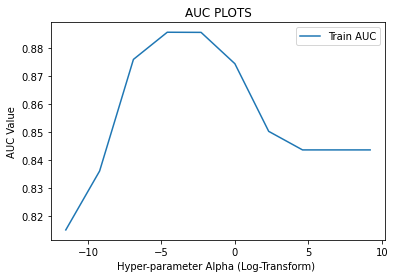

In [135]:
import math
alpha = []
print('Alpha','Log-Alpha')
for n in range(len(svm_cv_df.param_alpha)):
    alpha1 = svm_cv_df.param_alpha[n]
    x = math.log(alpha1)
    print(alpha1,x)
    alpha.append(x)

plt.plot(alpha,svm_cv_df.mean_test_score)
plt.legend(['Train AUC'], loc='upper right')
plt.title("AUC PLOTS")
plt.xlabel('Hyper-parameter Alpha (Log-Transform) ')
plt.ylabel('AUC Value')
plt.show()

Fitting a CalibratedClassifierCV to get probability scores:

In [136]:
svm_calib_clf = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = svm_clf.best_params_['alpha'])
svm_calib_clf.fit(X_train_pca, y_train)

calibrated_bow_clf = CalibratedClassifierCV(base_estimator=svm_calib_clf, cv='prefit', method='isotonic')
calibrated_bow_clf.fit(X_train_pca, y_train)

print("Best Parameters : ", calibrated_bow_clf.get_params(calibrated_bow_clf))

Best Parameters :  {'base_estimator__alpha': 0.01, 'base_estimator__average': False, 'base_estimator__class_weight': 'balanced', 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True, 'base_estimator__l1_ratio': 0.15, 'base_estimator__learning_rate': 'optimal', 'base_estimator__loss': 'hinge', 'base_estimator__max_iter': 1000, 'base_estimator__n_iter_no_change': 5, 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__power_t': 0.5, 'base_estimator__random_state': None, 'base_estimator__shuffle': True, 'base_estimator__tol': 0.001, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': SGDClassifier(alpha=0.01, class_weight='balanced'), 'cv': 'prefit', 'method': 'isotonic'}


In [137]:
best_svm = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = svm_clf.best_params_['alpha'])
best_svm.fit(X_train_pca, y_train)

predicted_labels_train = best_svm.predict(X_train_pca)
predict_train_prob = calibrated_bow_clf.predict_proba(X_train_pca)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train, predict_train_prob)

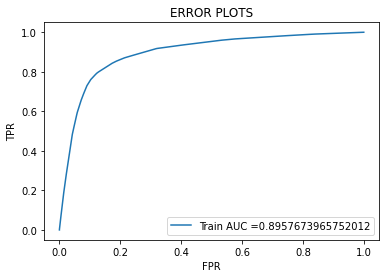

In [138]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

In [139]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(y_train,predicted_labels_train).ravel()
print(confusion_matrix(y_train,predicted_labels_train))

Train Confusion Matrix
[[16034  3157]
 [  296  1450]]


**Checking the decision boundary.**

In [140]:
SVM_train = pd.DataFrame()
SVM_train['churn'] = train['churn']
SVM_train['predicted_labels'] = predicted_labels_train
SVM_train['predicted_proba'] = predict_train_prob
SVM_train.head()

,churn,predicted_labels,predicted_proba
6001,0,0,0.038728
11801,0,0,0.018607
25425,0,0,0.016977
5812,0,0,0.054118
13131,0,0,0.038728


     probability  accuracy  sensitivity  specificity
0.0          0.0  0.083536     1.000000     0.000156
0.1          0.1  0.870564     0.792096     0.877703
0.2          0.2  0.894589     0.729668     0.909593
0.3          0.3  0.907007     0.645475     0.930801
0.4          0.4  0.917992     0.484536     0.957428
0.5          0.5  0.919377     0.281214     0.977437
0.6          0.6  0.916798     0.003436     0.999896
0.7          0.7  0.916702     0.001145     1.000000
0.8          0.8  0.916702     0.001145     1.000000
0.9          0.9  0.916702     0.001145     1.000000


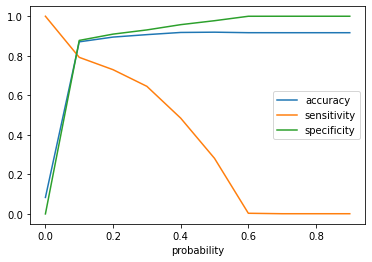

In [141]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
accu_sens_speci(SVM_train)

**Keeping the decision boundary at 0.15 as 0.1-0.2 is predicted to give good overall values across metrics.**

In [142]:
SVM_train['final_predicted'] = SVM_train.predicted_proba.map( lambda x: 1 if x > 0.15 else 0)
SVM_train.head()

,churn,predicted_labels,predicted_proba,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
6001,0,0,0.038728,1,0,0,0,0,0,0,0,0,0,0
11801,0,0,0.018607,1,0,0,0,0,0,0,0,0,0,0
25425,0,0,0.016977,1,0,0,0,0,0,0,0,0,0,0
5812,0,0,0.054118,1,0,0,0,0,0,0,0,0,0,0
13131,0,0,0.038728,1,0,0,0,0,0,0,0,0,0,0


Train Confusion Matrix after thresholding


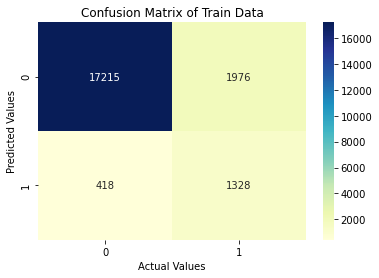

In [143]:
print('Train Confusion Matrix after thresholding')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(SVM_train.churn, SVM_train.final_predicted).ravel()
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')
plt.show()

In [144]:
confusion2 = metrics.confusion_matrix(SVM_train.churn, SVM_train.final_predicted)
conf_train = confusion2.copy()
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [145]:
# Let's check the overall accuracy.
svm_train_accuracy = metrics.accuracy_score(SVM_train.churn, SVM_train.final_predicted)
print('Train Accuracy : ', svm_train_accuracy)
# Let's see the sensitivity of our logistic regression model
svm_train_sensitivity = TP / float(TP+FN)
print('Train Sensitivity: ',svm_train_sensitivity)
# Let us calculate specificity
svm_train_specificity = TN / float(TN+FP)
print('Train Specificity : ',svm_train_specificity)
# Calculate false postive rate - predicting churn when customer does not have churned
svm_train_frp = FP/ float(TN+FP)
print('Train False Positive Rate : ', svm_train_frp)

Train Accuracy :  0.8856569709127382
Train Sensitivity:  0.7605956471935853
Train Specificity :  0.8970350685217029
Train False Positive Rate :  0.10296493147829712


In [146]:
print("Train Precision : ", precision_score(SVM_train.churn, SVM_train.final_predicted))
print("Train Recall : ", recall_score(SVM_train.churn, SVM_train.final_predicted))

Train Precision :  0.4019370460048426
Train Recall :  0.7605956471935853


### SVM On Test Dataset:

In [147]:
predicted_labels_test = best_svm.predict(X_test_pca)
predict_test_prob = calibrated_bow_clf.predict_proba(X_test_pca)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_test_prob)

In [148]:
# Converting y_pred to a dataframe which is an array
SVM_test = pd.DataFrame()
SVM_test['actual_label']=y_test
SVM_test['predicted_labels']=predicted_labels_test
SVM_test['predicted_prob'] = predict_test_prob
SVM_test.head()

,actual_label,predicted_labels,predicted_prob
5133,0,0,0.005227
26545,0,0,0.041096
4956,0,0,0.038728
161,0,0,0.018607
8148,0,0,0.007264


In [149]:
SVM_test['final_predicted'] = SVM_test.predicted_prob.map(lambda x: 1 if x > 0.15 else 0)
SVM_test.head()

,actual_label,predicted_labels,predicted_prob,final_predicted
5133,0,0,0.005227,0
26545,0,0,0.041096,0
4956,0,0,0.038728,0
161,0,0,0.018607,0
8148,0,0,0.007264,0


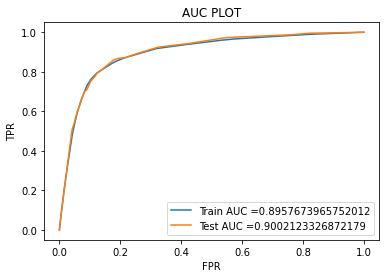

In [150]:
# Plotting the AUC curve on Train and Test Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOT")
plt.show()

In [151]:
confusion2 = metrics.confusion_matrix(SVM_test.actual_label, SVM_test.final_predicted )
confusion2

array([[7434,  852],
       [ 170,  517]], dtype=int64)

In [152]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [153]:
# Let's check the overall accuracy.
svm_test_accuracy = metrics.accuracy_score(SVM_test.actual_label, SVM_test.final_predicted)
print('Test Accuracy : ', svm_test_accuracy)
# Let's see the sensitivity of our logistic regression model
svm_test_sensitivity = TP / float(TP+FN)
print('Test Sensitivity: ',svm_test_sensitivity)
# Let us calculate specificity
svm_test_specificity = TN / float(TN+FP)
print('Test Specificity : ',svm_test_specificity)
# Calculate false postive rate - predicting churn when customer does not have churned
svm_test_frp = FP/ float(TN+FP)
print('Test False Positive Rate : ', svm_test_frp)

Test Accuracy :  0.8861027527025521
Test Sensitivity:  0.75254730713246
Test Specificity :  0.8971759594496741
Test False Positive Rate :  0.10282404055032585


In [154]:
print("Test Precision : ", precision_score(SVM_test.actual_label, SVM_test.final_predicted))
print("Test Recall : ", recall_score(SVM_test.actual_label, SVM_test.final_predicted))

Test Precision :  0.3776479181884587
Test Recall :  0.75254730713246


In [155]:
churn_train = SVM_train.copy()
churn_test = SVM_test.copy()
churn_train.drop('predicted_labels', axis = 1, inplace = True)
churn_test.drop('predicted_labels', axis = 1, inplace = True)
churn_train.rename(columns = {'final_predicted':'predicted_labels', 'actual_label':'churn'}, inplace =True)
churn_test.rename(columns = {'final_predicted':'predicted_labels', 'actual_label':'churn'}, inplace =True)
loc_perf = perf_metrics(conf_train,confusion2)
model_metrics.loc[('SVM Model','train'),:] = loc_perf[:1].values[-1]
model_metrics.loc[('SVM Model','test'),:] = loc_perf[1:2].values[-1]
model_metrics

accuracy sensitivity sepcificity    FPR
model_type     dataset                                        
LR Model1_0.4  train       0.75       0.878       0.739  0.261
               test       0.745       0.898       0.732  0.268
LR Model1_0.45 train      0.786       0.859       0.779  0.221
               test       0.783       0.872       0.775  0.225
LR Model2_0.4  train      0.751       0.886       0.738  0.262
               test       0.745       0.894       0.732  0.268
DT Model       train      0.794       0.848        0.79   0.21
               test       0.775       0.745       0.778  0.222
RF Model       train      0.795       0.922       0.784  0.216
               test       0.776       0.837       0.771  0.229
SVM Model      train      0.886       0.761       0.897  0.103
               test       0.886       0.753       0.897  0.103

### Model Conclusions
- Best model to use to predict whether a high-value customer will churn or not, in near future is LR model with cut-off probability 0.4 (Model 2). It's performance metrics are:

In [156]:
# best model details
model_metrics.loc['LR Model2_0.4',:]

,accuracy,sensitivity,sepcificity,FPR
dataset,,,,
train,0.751,0.886,0.738,0.262
test,0.745,0.894,0.732,0.268


Since it is more significant to cover all possible churn customers, so we are giving more importance to **Sensitivity** metric.


**Hyper-parameter tuned Logistic Regression with decision boundary at 0.4 gives the best overall Sensitivity value at 0.88 for both train and test. It also has good specificity and low False Positive Rate.**

### Feature Importance:

In [157]:
# build a random forest model to identify relative feature importance
tuned_param = [{'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
               'n_estimators':[5, 10, 50, 100, 200, 500, 1000]
               }]

# Using GridSearchCV
rf_feat_model = GridSearchCV(RandomForestClassifier(class_weight={0:0.1, 1: 0.9},max_features = 'auto', random_state = 0, n_jobs = -1),
                        tuned_param,cv = 5, verbose = 1, scoring = 'roc_auc')
rf_feat_model.fit(X_train_scaled, y_train)

print(rf_feat_model.best_estimator_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 14.9min finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=10,
                       n_estimators=500, n_jobs=-1, random_state=0)


In [158]:
train.columns

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6',
       ...
       'arpu_data_6', 'total_data_rech_amt_6', 'total_data_vol_7',
       'count_monthly_data_rec_7', 'arpu_data_7', 'total_data_rech_amt_7',
       'total_data_vol_8', 'count_monthly_data_rec_8', 'arpu_data_8',
       'total_data_rech_amt_8'],
      dtype='object', length=119)

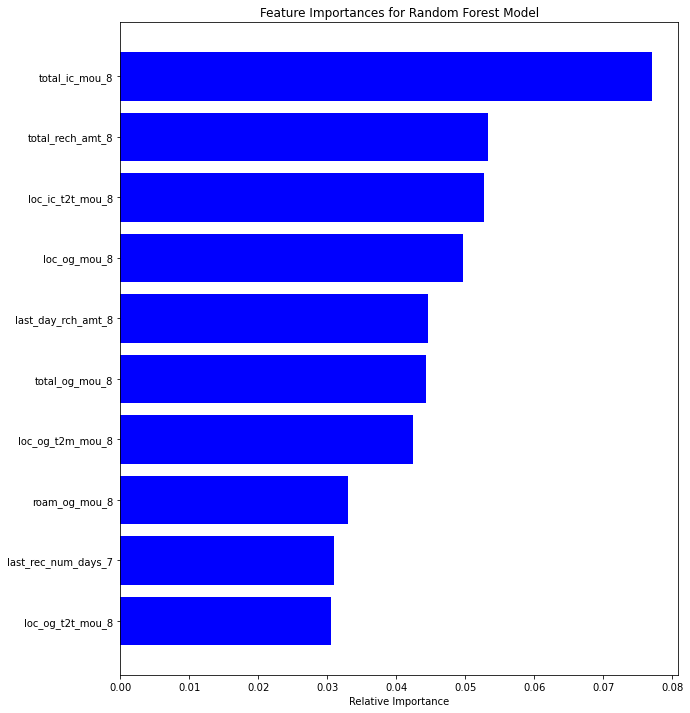

In [159]:
# visualise the feature importance
features = train.columns
importances = rf_feat_model.best_estimator_.feature_importances_
indices = (np.argsort(importances))[-10:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances for Random Forest Model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Recommend strategies to manage customer churn

#### Important predictors for churn identification in the order of relative importance are as follows:
1. total_ic_mou_8
2. total_rech_amt_8
3. loc_ic_t2t_mou_8
4. loc_og_mou_8
5. last_day_rch_amt_8
6. total_og_mou_8
7. loc_og_t2m_mou_8



**Conclusions:**

- There is a considerable drop in relative relevance after loc_og_t2m_mou_8



- Total minutes of usage for incoming calls (total_ic_mou_8) in action phase (August) has the highest importance in predicting customer churn. 


- The next 2 important features are total amount of recharge (total_rech_amt_8) and minutes of usage for local incoming call (within the same network - loc_ic_t2t_mou_8) by customer in action phase. They have almost same relative importance.


- Usage by customer for local outgoing call in action phase is another relevant feature to identify churn.


- Amount of recharge done on the last day (last_day_rch_amt_8) and total outgoing call usage by the customer in action phase are also good indicators of churn.

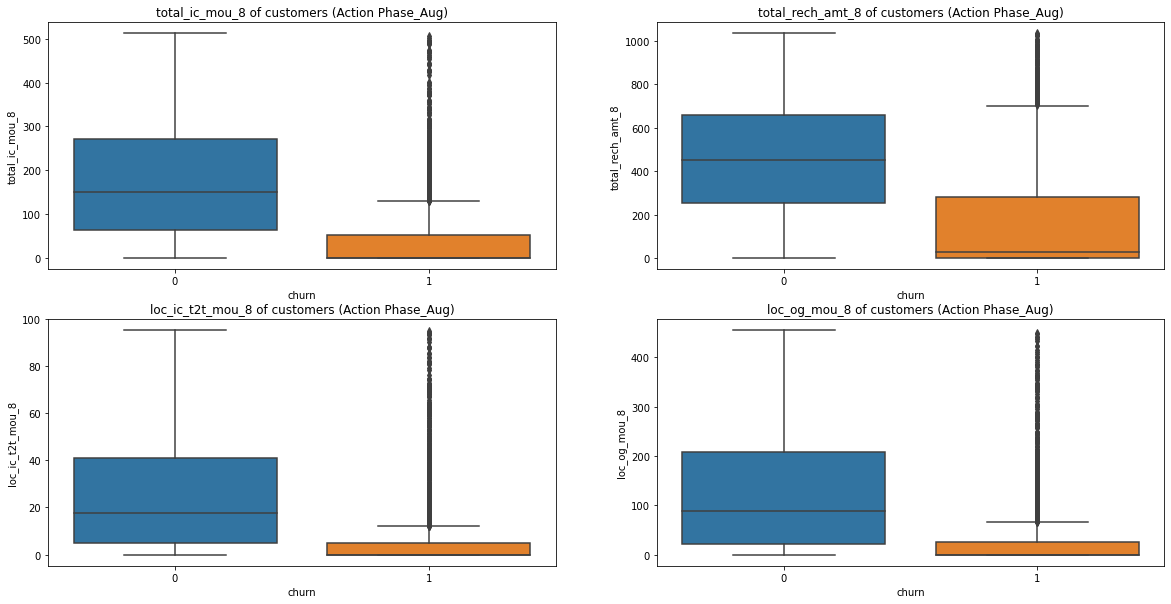

In [161]:
# check the distribution of top 4 parameters in August (Action phase -July+August)
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.boxplot(y = pref_cust_df.loc[pref_cust_df.total_ic_mou_8 <= (pref_cust_df.total_ic_mou_8.quantile(q = 0.25) + 
                                                 1.5*(pref_cust_df.total_ic_mou_8.quantile(q = 0.75)-
                                                      pref_cust_df.total_ic_mou_8.quantile(q = 0.25))), 'total_ic_mou_8'], x = pref_cust_df.churn)

plt.title('total_ic_mou_8 of customers (Action Phase_Aug)')

plt.subplot(2,2,2)
sns.boxplot(y = pref_cust_df.loc[pref_cust_df.total_rech_amt_8 <= (pref_cust_df.total_rech_amt_8.quantile(q = 0.25) + 
                                                 1.5*(pref_cust_df.total_rech_amt_8.quantile(q = 0.75)-
                                                      pref_cust_df.total_rech_amt_8.quantile(q = 0.25))), 'total_rech_amt_8'], 
            x = pref_cust_df.churn)

plt.title('total_rech_amt_8 of customers (Action Phase_Aug)')

plt.subplot(2,2,3)
sns.boxplot(y = pref_cust_df.loc[pref_cust_df.loc_ic_t2t_mou_8 <= (pref_cust_df.loc_ic_t2t_mou_8.quantile(q = 0.25) + 
                                                 1.5*(pref_cust_df.loc_ic_t2t_mou_8.quantile(q = 0.75)-
                                                      pref_cust_df.loc_ic_t2t_mou_8.quantile(q = 0.25))), 'loc_ic_t2t_mou_8'], 
            x = pref_cust_df.churn)
plt.title('loc_ic_t2t_mou_8 of customers (Action Phase_Aug)')

plt.subplot(2,2,4)
sns.boxplot(y = pref_cust_df.loc[pref_cust_df.loc_og_mou_8 <= (pref_cust_df.loc_og_mou_8.quantile(q = 0.25) + 
                                                 1.5*(pref_cust_df.loc_og_mou_8.quantile(q = 0.75)-
                                                      pref_cust_df.loc_og_mou_8.quantile(q = 0.25))), 'loc_og_mou_8'], 
            x = pref_cust_df.churn)

plt.title('loc_og_mou_8 of customers (Action Phase_Aug)')

plt.show()

- As per the above analysis, the top features indicating churn have been identified as  total_ic_mou_8, total_rech_amt_8, loc_ic_t2t_mou_8, etc.
- The most important feature total_ic_mou_8 exhibits very low usage of incoming call services by customers who are very much likely to churn towards the end of action phase.
- total_rech_amt_8 of churned customers also show considerable difference compared to non-churners
- Similar pattern can be observed between churned and non-churned customers during the action phase (Aug)


- Hence, monitoring the above-mentioned parameters can help in early identification of high value customer churn and to take necessary actions